# Duolingo Datathon Dataset C Analysis

## I. Pip Install Required Pakages

In [42]:
%pip install pyspark pandas numpy matplotlib seaborn duckdb scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 46.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 54.0 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



## II. Prepare Dataset
Working with training dataset (~87M rows, 4GB extracted)

### 1. Import Libraries

In [2]:
# Import libraries
import os
import glob
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Initialize Spark Session

In [3]:
# Initialize Spark Session with optimized config for this dataset
spark = SparkSession.builder \
    .appName("duolingo_datathon") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

# Explanation of parameters:
# - appName("duolingo_datathon"): Names this Spark application (appears in logs/UI)
# - spark.driver.memory = "4g": Allocates 4GB RAM to the driver process (orchestrates tasks)
# - spark.sql.shuffle.partitions = "8": Sets partitions for shuffle ops (joins/groupBy)
#   Default is 200, but 8 is efficient for 30K-row sample on single machine
# - getOrCreate(): Creates new session OR reuses existing one (prevents errors on re-run)

print(f"Spark Version: {spark.version}")
print(f"Driver Memory: {spark.sparkContext.getConf().get('spark.driver.memory')}")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/24 14:31:44 WARN Utils: Your hostname, codespaces-80ea76, resolves to a loopback address: 127.0.0.1; using 10.0.13.254 instead (on interface eth0)
26/02/24 14:31:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/24 14:31:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 4.1.1
Driver Memory: 4g


### 3. Locate All Training Directories

In [4]:
# Locate where the extracted parquet data is stored

train_dir = "/workspaces/datathon-duolingo"
train_parts = sorted([d for d in glob.glob(f"{train_dir}/train-part-*") if os.path.isdir(d)])

# glob.glob() finds all directories matching the pattern "train-part-*"
# os.path.isdir() filters to keep only directories (not files)
# sorted() ensures consistent ordering (train-part-1, train-part-2, train-part-3)

print(f"Found {len(train_parts)} training data partitions:")
for tp in train_parts:
    print(f"  - {tp}")

Found 3 training data partitions:
  - /workspaces/datathon-duolingo/train-part-1
  - /workspaces/datathon-duolingo/train-part-2
  - /workspaces/datathon-duolingo/train-part-3


### 4. Verify Data Integrity

In [5]:
# Quick test: read one parquet file with DuckDB to verify integrity (only 3 rows)
# Ensure the extracted parquet files are readable before loading the full dataset

import duckdb
import glob

# Find and select ONE test parquet file from the first partition
test_file = glob.glob("/workspaces/datathon-duolingo/train-part-1/*.parquet")[0]
print(f"Testing parquet: {test_file}")

try:
    # Create DuckDB connection (in-memory database)
    conn = duckdb.connect()
    
    # Read only 3 rows for quick verification (LIMIT 3 avoids loading large files)
    result = conn.execute(f"SELECT * FROM read_parquet('{test_file}') LIMIT 3").df()
    
    # Display results to verify structure
    print(f"\nShape: {result.shape}")
    print(f"\nColumns: {result.columns.tolist()}")
    print(f"\nFirst 3 rows:")
    print(result)
    
except Exception as e:
    # If read fails, print detailed error message for debugging
    print(f"Error: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Testing parquet: /workspaces/datathon-duolingo/train-part-1/part-00000-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet

Shape: (3, 6)

Columns: ['datetime', 'ui_language', 'eligible_templates', 'history', 'selected_template', 'session_end_completed']

First 3 rows:
   datetime ui_language              eligible_templates  \
0  0.153461          en  [G, E, B, A, K, H, J, L, F, D]   
1  2.827303          es  [G, E, B, A, K, H, J, L, F, D]   
2  2.792662          en     [G, E, B, K, H, J, L, F, D]   

                                             history selected_template  \
0  [{'template': 'A', 'n_days': 28.19564819335937...                 B   
1  [{'template': 'A', 'n_days': 29.836181640625},...                 A   
2  [{'template': 'G', 'n_days': 8.197543144226074...                 J   

   session_end_completed  
0                  False  
1                   True  
2                   True  


### 5. Load A Sample of 30K Rows

In [6]:
# Load a 30K sample from ALL 3 partitions using DuckDB (memory-efficient approach)
# DuckDB reads parquet files directly without loading everything into memory
# This is much faster and safer than Spark for small-to-medium datasets in dev environments

import duckdb
import glob

# Step 1: Find all parquet files across the 3 training partitions
parquet_files = sorted(glob.glob("/workspaces/datathon-duolingo/train-part-*/part-*.parquet"))
print(f"Found {len(parquet_files)} parquet files total")
print("Files:")
for f in parquet_files:
    print(f"  - {f}")

try:
    # Step 2: Create DuckDB connection (in-memory analytical database)
    conn = duckdb.connect()
    
    # Step 3: Get total row count WITHOUT loading data (reads parquet metadata only)
    # This is FAST because it doesn't scan the actual data
    total_rows = conn.execute(f"""
        SELECT COUNT(*) as total_rows 
        FROM read_parquet({parquet_files})
    """).fetchone()[0]
    
    print(f"\nTotal rows across all partitions: {total_rows:,}")
    
    # Step 4: Load a RANDOM SAMPLE of 30,000 rows (memory-safe)
    # USING SAMPLE 30000 → DuckDB picks 30K rows randomly from all 87M rows
    # This avoids loading 2-4GB of data and potentially crashing the kernel
    print("\nLoading sample (30K rows randomly sampled)...")
    df_train = conn.execute(f"""
        SELECT * FROM read_parquet({parquet_files})
        USING SAMPLE 30000
    """).df()
    
    # Step 5: Display the loaded sample for verification
    print(f"Loaded sample: {len(df_train):,} rows")
    print(f"\nColumns: {df_train.columns.tolist()}")
    print(f"\nData types:\n{df_train.dtypes}")
    print(f"\nFirst 5 rows:")
    print(df_train.head())
    
    # NOTE: To load the FULL dataset (all 87M rows), replace the query above with:
    # df_train = conn.execute(f"SELECT * FROM read_parquet({parquet_files})").df()
    # WARNING: This requires ~2-4GB RAM and may crash the kernel in constrained environments
    
except Exception as e:
    print(f"Error: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Found 3 parquet files total
Files:
  - /workspaces/datathon-duolingo/train-part-1/part-00000-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet
  - /workspaces/datathon-duolingo/train-part-2/part-00001-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet
  - /workspaces/datathon-duolingo/train-part-3/part-00002-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet

Total rows across all partitions: 87,665,839

Loading sample (30K rows randomly sampled)...
Loaded sample: 30,000 rows

Columns: ['datetime', 'ui_language', 'eligible_templates', 'history', 'selected_template', 'session_end_completed']

Data types:
datetime                 float64
ui_language                  str
eligible_templates        object
history                   object
selected_template            str
session_end_completed       bool
dtype: object

First 5 rows:
    datetime ui_language              eligible_templates  \
0   3.149062          en  [G, E, B, A, K, H, J, L, F, D]   
1  11.205116          e

## III. Exploratory Analysis

### 1. Data Profiling

In [7]:
# Basic statistics (pandas-based)
print("=== DATA PROFILING ===\n")

# Row count and memory usage
print(f"Total rows in sample: {len(df_train):,}")
print(f"Number of columns: {len(df_train.columns)}")
print(f"Memory usage: {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Null values
print("\nMissing values:")
print(df_train.isnull().sum())

# Column data types
print("\nData types:")
print(df_train.dtypes)

# Basic statistics for numeric columns
print("\nNumeric column statistics:")
print(df_train.describe())

=== DATA PROFILING ===

Total rows in sample: 30,000
Number of columns: 6
Memory usage: 11.95 MB

Missing values:
datetime                 0
ui_language              0
eligible_templates       0
history                  0
selected_template        0
session_end_completed    0
dtype: int64

Data types:
datetime                 float64
ui_language                  str
eligible_templates        object
history                   object
selected_template            str
session_end_completed       bool
dtype: object

Numeric column statistics:
           datetime
count  30000.000000
mean       7.846155
std        4.303406
min        0.000046
25%        4.165113
50%        8.051615
75%       11.554039
max       14.999896


### 2. Target variables (Binary)
 (session_end_complete)

=== TARGET VARIABLE ANALYSIS ===

Session completion distribution:
session_end_completed
False    25709
True      4291
Name: count, dtype: int64

Completion rate (True): 14.30%
Non-completion rate (False): 85.70%


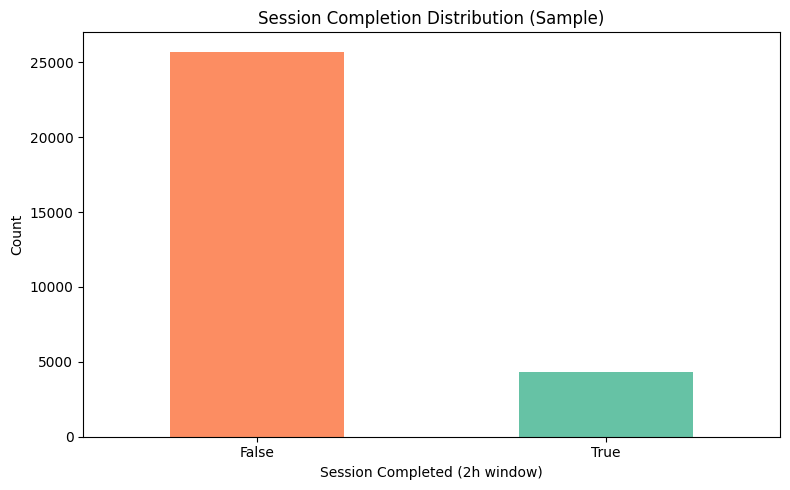

In [8]:
# Target variable analysis (pandas-based)
print("=== TARGET VARIABLE ANALYSIS ===\n")

# Session completion rate
completion_counts = df_train['session_end_completed'].value_counts()
print("Session completion distribution:")
print(completion_counts)

completion_pct = (completion_counts / completion_counts.sum() * 100)
print(f"\nCompletion rate (True): {completion_pct.get(True, 0):.2f}%")
print(f"Non-completion rate (False): {completion_pct.get(False, 0):.2f}%")

# Visualize
plt.figure(figsize=(8, 5))
completion_counts.plot(kind='bar', color=['#fc8d62', '#66c2a5'])
plt.title('Session Completion Distribution (Sample)')
plt.xlabel('Session Completed (2h window)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.Datetime (Continuous)

#### 1. Basic Statistics
1. summary statistics
2. temporal distribution (quantiles)
3. time resolution

In [10]:
# === DATETIME STATISTICS ===
# IMPORTANT DISCOVERY: Despite what the dataset description says,
# the datetime column is actually in DAYS, not seconds!
# Values range from 0 to ~15, representing the first 15 days of the experiment.
# 0 = day 0 (beginning), 15 = day 15 (end of training period)

print("=== DATETIME COLUMN ANALYSIS ===\n")

# 1. Summary Statistics
dt_min = df_train['datetime'].min()
dt_max = df_train['datetime'].max()
dt_mean = df_train['datetime'].mean()
dt_median = df_train['datetime'].median()
dt_std = df_train['datetime'].std()

print("The datetime column represents DAYS since experiment start:")
print(f"  Minimum: {dt_min:.2f} days (start of experiment)")
print(f"  Maximum: {dt_max:.2f} days (end of training period)")
print(f"  Mean: {dt_mean:.2f} days")
print(f"  Median: {dt_median:.2f} days")
print(f"  Standard deviation: {dt_std:.2f} days")

print(f"\nExperiment duration covered: {dt_max - dt_min:.2f} days")

# 2. Temporal Distribution - when do notifications happen?
print("\n--- Temporal Distribution (Quartiles) ---")
quartiles = df_train['datetime'].quantile([0.25, 0.5, 0.75])
print(f"  25% of notifications sent by day: {quartiles[0.25]:.2f}")
print(f"  50% of notifications sent by day: {quartiles[0.5]:.2f} (median)")
print(f"  75% of notifications sent by day: {quartiles[0.75]:.2f}")

# What this means:
# - If median is ~8 days, notifications are relatively evenly spread
# - If median is < 7.5 days, more notifications sent early in experiment
# - If median is > 7.5 days, more notifications sent later

# 3. Convert to HOURS for finer-grained time-of-day analysis
print("\n--- Time Resolution ---")
print(f"Since values are in days, decimal part represents time within the day:")
print(f"Example: 5.25 days = Day 5, at 6th hour from baseline (0.25 × 24 hours = 6 hours)")
print(f"Example: 10.75 days = Day 10, at 18th hour from baseline (0.75 × 24 hours = 18 hours)")

=== DATETIME COLUMN ANALYSIS ===

The datetime column represents DAYS since experiment start:
  Minimum: 0.00 days (start of experiment)
  Maximum: 15.00 days (end of training period)
  Mean: 7.85 days
  Median: 8.05 days
  Standard deviation: 4.30 days

Experiment duration covered: 15.00 days

--- Temporal Distribution (Quartiles) ---
  25% of notifications sent by day: 4.17
  50% of notifications sent by day: 8.05 (median)
  75% of notifications sent by day: 11.55

--- Time Resolution ---
Since values are in days, decimal part represents time within the day:
Example: 5.25 days = Day 5, at 6th hour from baseline (0.25 × 24 hours = 6 hours)
Example: 10.75 days = Day 10, at 18th hour from baseline (0.75 × 24 hours = 18 hours)


#### 2. Data Manipulation
1. within-day patterns: extract second, hour, minute
2. day_index for experiment timeline
3. day-of-week proxy
4. cyclic encoding for time-of-day
5. cyclic encoding for weekly pattern (proxy)
6. quick check


In [11]:

import numpy as np  
# === TEMPORAL FEATURES (days -> hours/minutes + cycles) ===
# datetime is in DAYS since experiment start
seconds_in_day = 24 * 60 * 60

# 4.Within-day patterns: extract second, hour, minute
df_train['seconds_into_day'] = (df_train['datetime'] % 1) * seconds_in_day
df_train['hour'] = (df_train['seconds_into_day'] // 3600).astype(int)
df_train['minute'] = ((df_train['seconds_into_day'] % 3600) // 60).astype(int)

# 5. Day index (0–14) for experiment timeline
df_train['day_index'] = df_train['datetime'].astype(int)

# 6. Day-of-week proxy (0–6) since we don't have absolute calendar
df_train['dow_proxy'] = (df_train['day_index'] % 7).astype(int)

# 7. Cyclical encoding for time-of-day
df_train['hour_sin'] = np.sin(2 * np.pi * df_train['hour'] / 24)
df_train['hour_cos'] = np.cos(2 * np.pi * df_train['hour'] / 24)

# 8. Cyclical encoding for weekly pattern (proxy)
df_train['dow_sin'] = np.sin(2 * np.pi * df_train['dow_proxy'] / 7)
df_train['dow_cos'] = np.cos(2 * np.pi * df_train['dow_proxy'] / 7)

# 9. Quick checks
print(df_train[['datetime','day_index','hour','minute','dow_proxy']].head())
print(df_train[['hour','minute']].describe())



    datetime  day_index  hour  minute  dow_proxy
0   3.149062          3     3      34          3
1  11.205116         11     4      55          4
2   1.327755          1     7      51          1
3   9.309120          9     7      25          2
4   2.675671          2    16      12          2
               hour        minute
count  30000.000000  30000.000000
mean      12.646900     29.695433
std        6.237092     17.128308
min        0.000000      0.000000
25%        8.000000     15.000000
50%       13.000000     30.000000
75%       18.000000     44.000000
max       23.000000     59.000000


#### 3. Within-day Pattern
1. hourly count
2. hourly sucess rate

=== HOURLY NOTIFICATION COUNTS ===

    hour  notifications
0      0            795
1      1            678
2      2            721
3      3            757
4      4            763
5      5            872
6      6            995
7      7           1122
8      8           1355
9      9           1568
10    10           1432
11    11           1479
12    12           1549
13    13           1627
14    14           1963
15    15           1987
16    16           1317
17    17           1079
18    18           1189
19    19           1302
20    20           1669
21    21           1624
22    22           1437
23    23            720


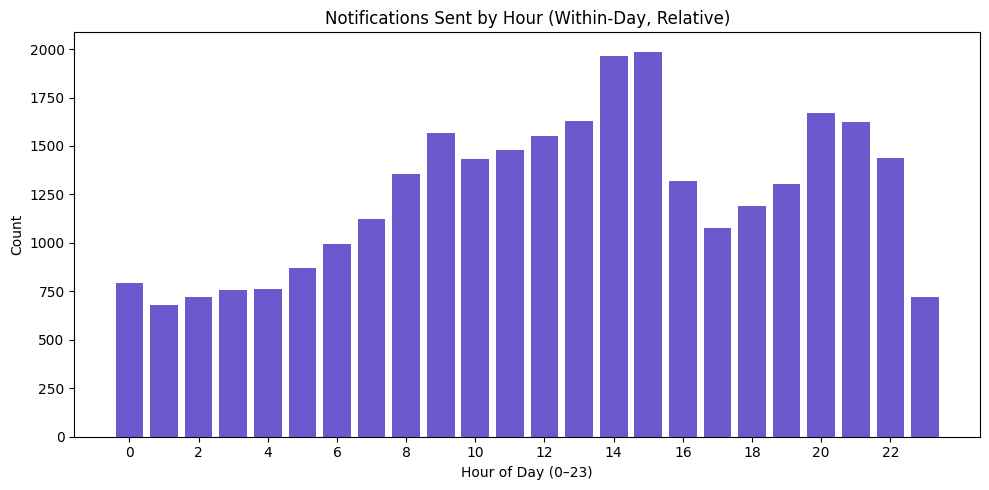

=== HOURLY SUCCESS RATE ===

    hour  total  completed  success_rate
0      0    795        153      0.192453
1      1    678        117      0.172566
2      2    721        104      0.144244
3      3    757        117      0.154557
4      4    763         88      0.115334
5      5    872        114      0.130734
6      6    995        131      0.131658
7      7   1122        164      0.146168
8      8   1355        187      0.138007
9      9   1568        191      0.121811
10    10   1432        175      0.122207
11    11   1479        165      0.111562
12    12   1549        176      0.113622
13    13   1627        198      0.121696
14    14   1963        276      0.140601
15    15   1987        346      0.174132
16    16   1317        189      0.143508
17    17   1079        116      0.107507
18    18   1189        139      0.116905
19    19   1302        169      0.129800
20    20   1669        255      0.152786
21    21   1624        317      0.195197
22    22   1437        284  

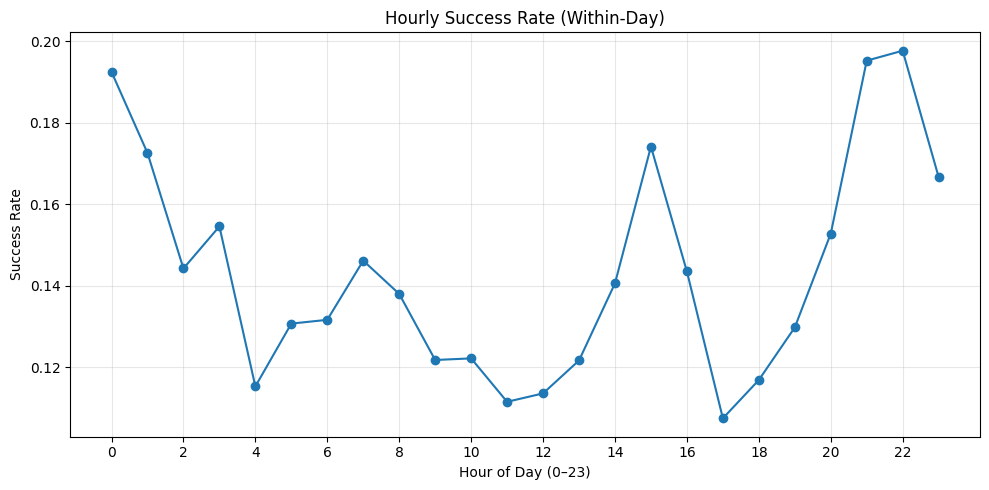

In [12]:
# 1. === HOURLY NOTIFICATION COUNTS ===
print("=== HOURLY NOTIFICATION COUNTS ===\n")

# Ensure hour exists (already created above)
#seconds_in_day = 24 * 60 * 60
#df_train['seconds_into_day'] = (df_train['datetime'] % 1) * seconds_in_day
#df_train['hour'] = (df_train['seconds_into_day'] // 3600).astype(int)

hourly_counts = (
    df_train.groupby('hour')
    .size()
    .reset_index(name='notifications')
    .sort_values('hour')
)

print(hourly_counts)

plt.figure(figsize=(10, 5))
plt.bar(hourly_counts['hour'], hourly_counts['notifications'], color='slateblue')
plt.title('Notifications Sent by Hour (Within-Day, Relative)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Count')
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()


# 2. === HOURLY SUCCESS RATE (within-day) ===
print("=== HOURLY SUCCESS RATE ===\n")

# Ensure hour exists
seconds_in_day = 24 * 60 * 60
df_train['seconds_into_day'] = (df_train['datetime'] % 1) * seconds_in_day
df_train['hour'] = (df_train['seconds_into_day'] // 3600).astype(int)

hourly_success = (
    df_train.groupby('hour')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
    .sort_values('hour')
)

print(hourly_success)

plt.figure(figsize=(10, 5))
plt.plot(hourly_success['hour'], hourly_success['success_rate'], marker='o')
plt.title('Hourly Success Rate (Within-Day)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Success Rate')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()


combined visual: count as bar, success rate as points

=== HOURLY COUNTS vs SUCCESS RATE (SUPERIMPOSED) ===



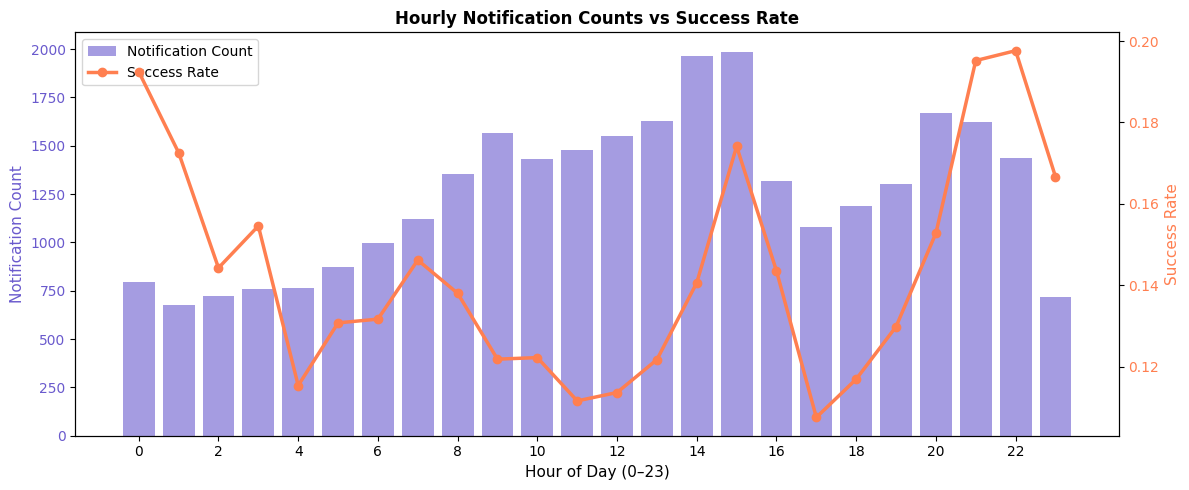

Key Insights:
  - Peak notifications: Hour 15
  - Peak success rate: Hour 22
  - Success rate range: 0.108 to 0.198


In [13]:
# === COMBINED HOURLY ANALYSIS: COUNTS + SUCCESS RATE ===
print("=== HOURLY COUNTS vs SUCCESS RATE (SUPERIMPOSED) ===\n")

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 5))

# Left y-axis: Notification counts (bar chart)
ax1.bar(hourly_counts['hour'], hourly_counts['notifications'], 
        alpha=0.6, color='slateblue', label='Notification Count')
ax1.set_xlabel('Hour of Day (0–23)', fontsize=11)
ax1.set_ylabel('Notification Count', color='slateblue', fontsize=11)
ax1.tick_params(axis='y', labelcolor='slateblue')
ax1.set_xticks(range(0, 24, 2))

# Right y-axis: Success rate (line chart)
ax2 = ax1.twinx()
ax2.plot(hourly_success['hour'], hourly_success['success_rate'], 
         color='coral', marker='o', linewidth=2.5, markersize=6, label='Success Rate')
ax2.set_ylabel('Success Rate', color='coral', fontsize=11)
ax2.tick_params(axis='y', labelcolor='coral')

# Title and legend
plt.title('Hourly Notification Counts vs Success Rate', fontsize=12, fontweight='bold')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

fig.tight_layout()
plt.show()

print("Key Insights:")
print(f"  - Peak notifications: Hour {hourly_counts.loc[hourly_counts['notifications'].idxmax(), 'hour']:.0f}")
print(f"  - Peak success rate: Hour {hourly_success.loc[hourly_success['success_rate'].idxmax(), 'hour']:.0f}")
print(f"  - Success rate range: {hourly_success['success_rate'].min():.3f} to {hourly_success['success_rate'].max():.3f}")

#### 4. Within Week Pattern
1. count vs day-of-week
2. success rate vs day-of-week

1. count vs. day of the week
2. sucess rate vs. day of the week

=== WEEKLY NOTIFICATION COUNTS ===

   dow_proxy  notifications
0          0           6163
1          1           3823
2          2           4156
3          3           3897
4          4           4038
5          5           3907
6          6           4016


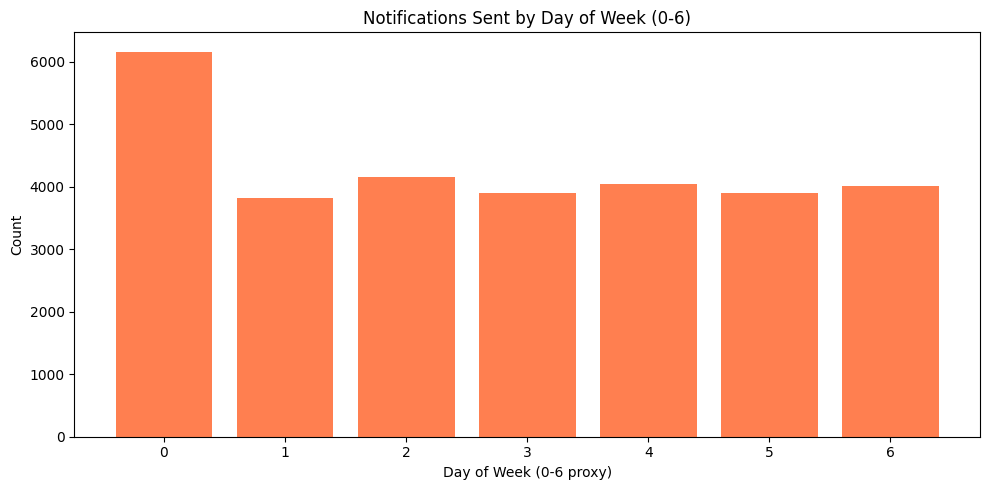

=== WEEKLY SEASONALITY (PROXY) ===

   dow_proxy  total  completed  success_rate
0          0   6163        953      0.154632
1          1   3823        593      0.155114
2          2   4156        628      0.151107
3          3   3897        444      0.113934
4          4   4038        505      0.125062
5          5   3907        533      0.136422
6          6   4016        635      0.158118


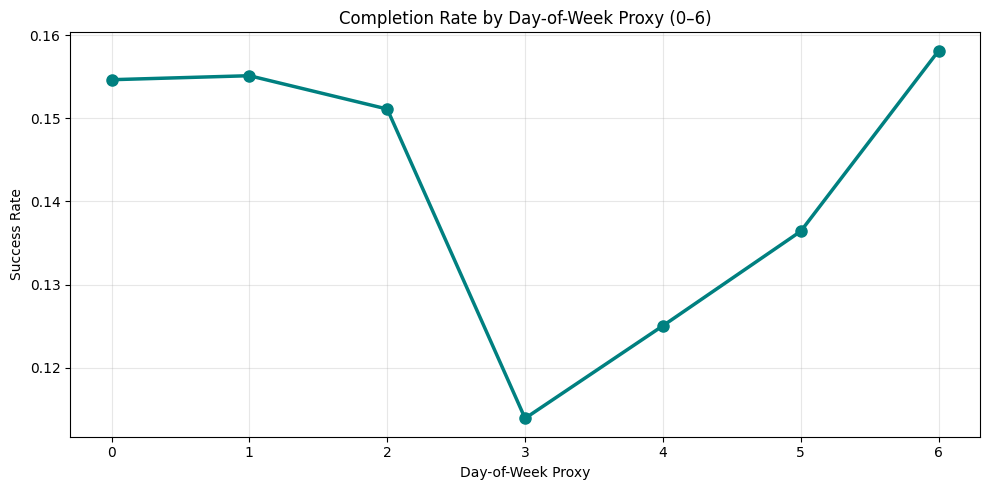

In [14]:
# 1. WEEKLY NOTIFICATION COUNTS ===
print("=== WEEKLY NOTIFICATION COUNTS ===\n")

# Ensure dow_proxy exists (already created above)
weekly_counts = (
    df_train.groupby('dow_proxy')
    .size()
    .reset_index(name='notifications')
    .sort_values('dow_proxy')
)

print(weekly_counts)

plt.figure(figsize=(10, 5))
plt.bar(weekly_counts['dow_proxy'], weekly_counts['notifications'], color='coral')
plt.title('Notifications Sent by Day of Week (0-6)')
plt.xlabel('Day of Week (0-6 proxy)')
plt.ylabel('Count')
plt.xticks(range(0, 7))
plt.tight_layout()
plt.show()



# 2. WEEKLY Success Rate (proxy) ===
print("=== WEEKLY SEASONALITY (PROXY) ===\n")

# Ensure day_index and dow_proxy exist
df_train['day_index'] = df_train['datetime'].astype(int)
df_train['dow_proxy'] = (df_train['day_index'] % 7).astype(int)

dow_success = (
    df_train.groupby('dow_proxy')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
)

print(dow_success)

plt.figure(figsize=(10, 5))
plt.plot(dow_success['dow_proxy'], dow_success['success_rate'], 
         color='teal', marker='o', linewidth=2.5, markersize=8)
plt.title('Completion Rate by Day-of-Week Proxy (0–6)')
plt.xlabel('Day-of-Week Proxy')
plt.ylabel('Success Rate')
plt.xticks(range(7))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ...existing code...

#### 5. 15 days pattern
1. count vs. day
2. success rate vs. day

=== DAILY NOTIFICATION COUNTS (ALL 15 DAYS) ===

    day_index  notifications
0           0           1877
1           1           1739
2           2           1962
3           3           1731
4           4           1816
5           5           1772
6           6           1879
7           7           2176
8           8           2084
9           9           2194
10         10           2166
11         11           2222
12         12           2135
13         13           2137
14         14           2110


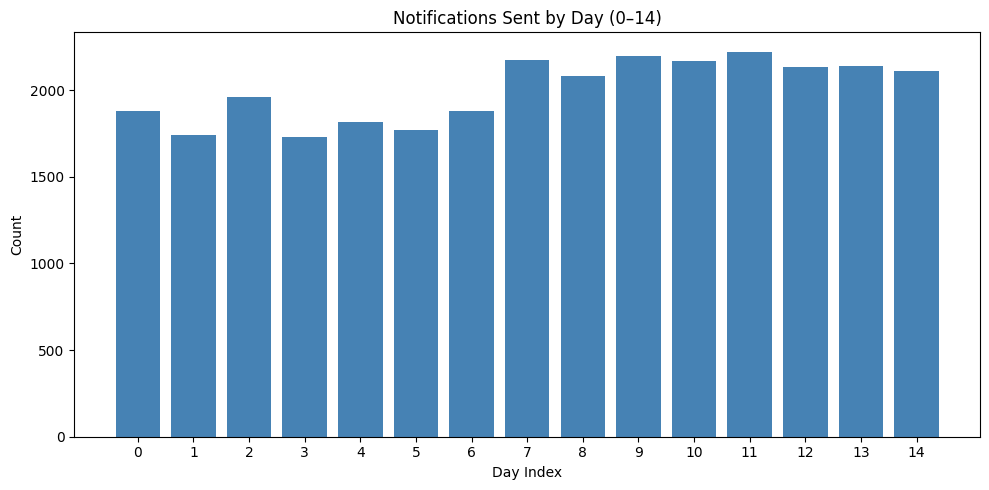

=== DAILY SUCCESS RATE (ALL 15 DAYS) ===

    day_index  total  completed  success_rate
0           0   1877        314      0.167288
1           1   1739        301      0.173088
2           2   1962        332      0.169215
3           3   1731        215      0.124206
4           4   1816        243      0.133811
5           5   1772        256      0.144470
6           6   1879        321      0.170836
7           7   2176        325      0.149357
8           8   2084        292      0.140115
9           9   2194        296      0.134913
10         10   2166        229      0.105725
11         11   2222        262      0.117912
12         12   2135        277      0.129742
13         13   2137        314      0.146935
14         14   2110        314      0.148815


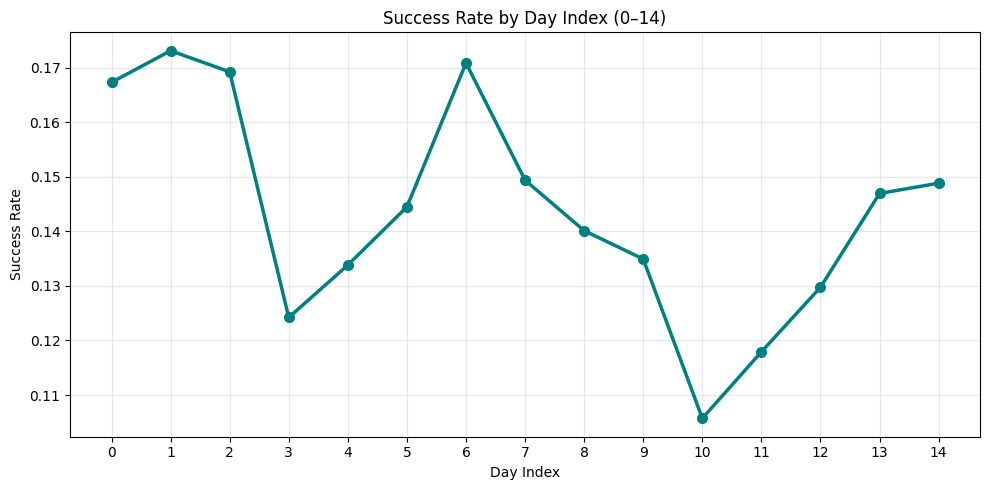

In [15]:
# === DAILY NOTIFICATION COUNTS (15 days) ===
print("=== DAILY NOTIFICATION COUNTS (ALL 15 DAYS) ===\n")

# Ensure day_index exists (already created from datetime)
# df_train['day_index'] = df_train['datetime'].astype(int)

daily_counts = (
    df_train.groupby('day_index')
    .size()
    .reset_index(name='notifications')
    .sort_values('day_index')
)

print(daily_counts)

plt.figure(figsize=(10, 5))
plt.bar(daily_counts['day_index'], daily_counts['notifications'], color='steelblue')
plt.title('Notifications Sent by Day (0–14)')
plt.xlabel('Day Index')
plt.ylabel('Count')
plt.xticks(range(0, 15))
plt.tight_layout()
plt.show()


# === DAILY SUCCESS RATE (15 days) ===
print("=== DAILY SUCCESS RATE (ALL 15 DAYS) ===\n")

daily_success = (
    df_train.groupby('day_index')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
    .sort_values('day_index')
)

print(daily_success)

plt.figure(figsize=(10, 5))
plt.plot(daily_success['day_index'], daily_success['success_rate'],
         color='teal', marker='o', linewidth=2.5, markersize=7)
plt.title('Success Rate by Day Index (0–14)')
plt.xlabel('Day Index')
plt.ylabel('Success Rate')
plt.xticks(range(0, 15))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. UI Language (Categorical)
1. UI language distribution (top 10)
2. UI top 10 lanugage vs. sucess rate

=== UI LANGUAGE DISTRIBUTION ===

Number of unique languages: 23

Top 10 languages:
ui_language
en    12327
es     7321
pt     2799
ru     1371
fr     1131
de      887
ar      568
zs      514
it      498
vi      476
Name: count, dtype: int64


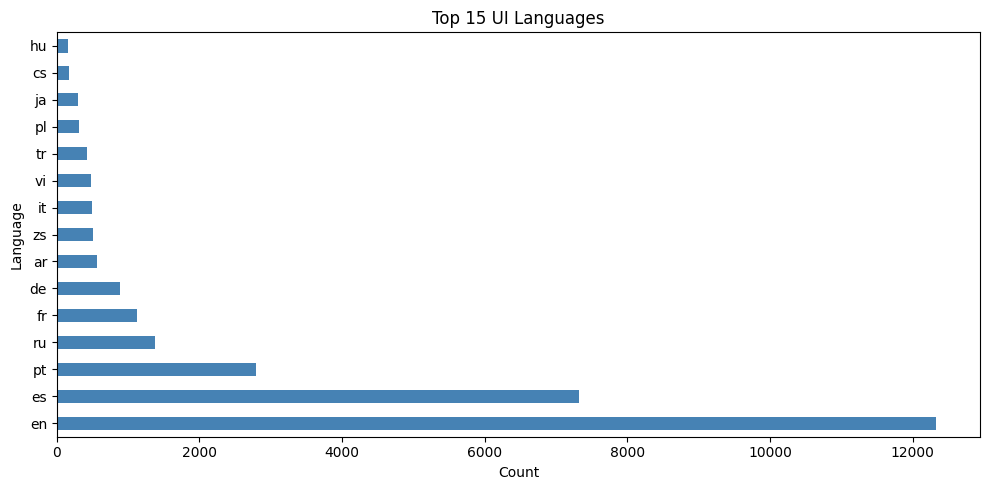


=== SUCCESS RATE BY TOP 10 LANGUAGES (BY COUNT) ===

   ui_language  total  success_rate
2           de    887      0.188275
11          it    498      0.180723
5           en  12327      0.161029
21          vi    476      0.153361
17          ru   1371      0.144420
7           fr   1131      0.143236
6           es   7321      0.121022
15          pt   2799      0.116827
22          zs    514      0.107004
0           ar    568      0.066901


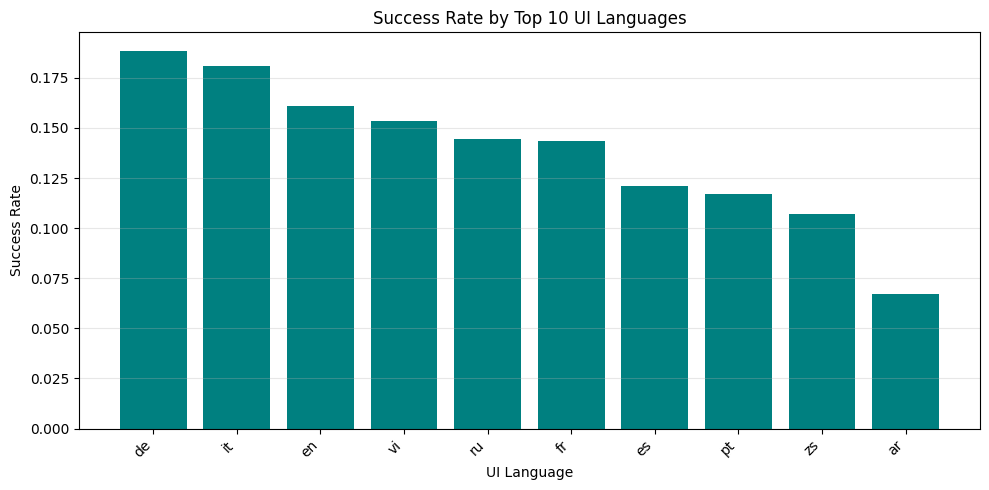

In [16]:
# 1. UI Language distribution
print("=== UI LANGUAGE DISTRIBUTION ===\n")
lang_counts = df_train['ui_language'].value_counts()
print(f"Number of unique languages: {len(lang_counts)}")
print(f"\nTop 10 languages:")
print(lang_counts.head(10))

# Visualize top languages
plt.figure(figsize=(10, 5))
lang_counts.head(15).plot(kind='barh', color='steelblue')
plt.title('Top 15 UI Languages')
plt.xlabel('Count')
plt.ylabel('Language')
plt.tight_layout()
plt.show()


# 2. Success rate vs. top 10 languages (bar chart)
print("\n=== SUCCESS RATE BY TOP 10 LANGUAGES (BY COUNT) ===\n")

lang_success = (
    df_train.groupby('ui_language')['session_end_completed']
    .agg(total='count', success_rate='mean')
    .reset_index()
)

lang_success_top10 = (
    lang_success.sort_values('total', ascending=False)
    .head(10)
    .sort_values('success_rate', ascending=False)
)

print(lang_success_top10)

plt.figure(figsize=(10, 5))
plt.bar(lang_success_top10['ui_language'], lang_success_top10['success_rate'], color='teal')
plt.title('Success Rate by Top 10 UI Languages')
plt.xlabel('UI Language')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 5. Selected Template (Categorical)
Template A and C should be the conditional templates for more active users. We can use these 2 templates to cluster users into active vs. nonactive.



=== SELECTED TEMPLATE DISTRIBUTION ===

Number of unique templates: 11

Template distribution:
selected_template
K    3188
E    3144
D    3118
B    3106
J    3101
L    3095
H    3090
G    3077
F    3062
A    1167
C     852
Name: count, dtype: int64


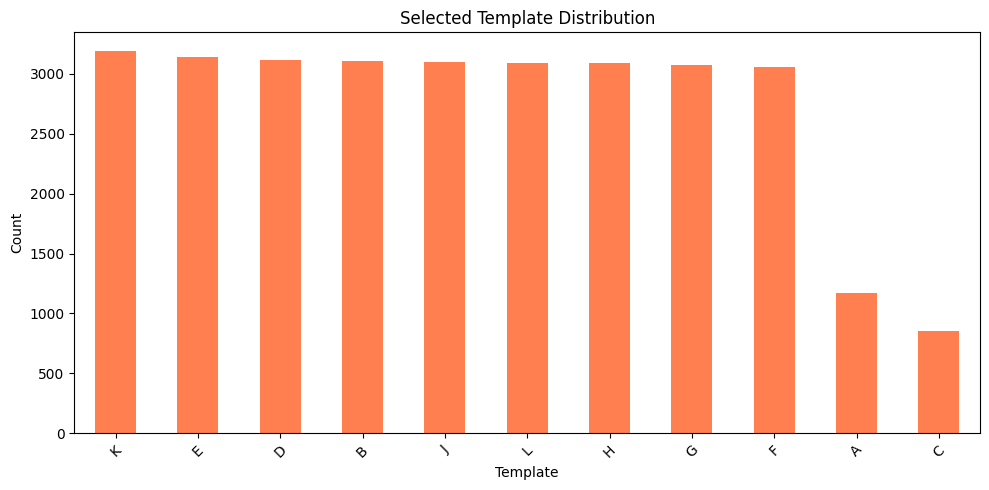

=== COMPLETION RATE BY TEMPLATE ===

                   total  completed  completion_rate
selected_template                                   
C                    852        345         0.404930
A                   1167        308         0.263925
H                   3090        415         0.134304
L                   3095        413         0.133441
D                   3118        414         0.132777
J                   3101        411         0.132538
G                   3077        405         0.131622
E                   3144        412         0.131043
F                   3062        398         0.129980
B                   3106        388         0.124920
K                   3188        382         0.119824


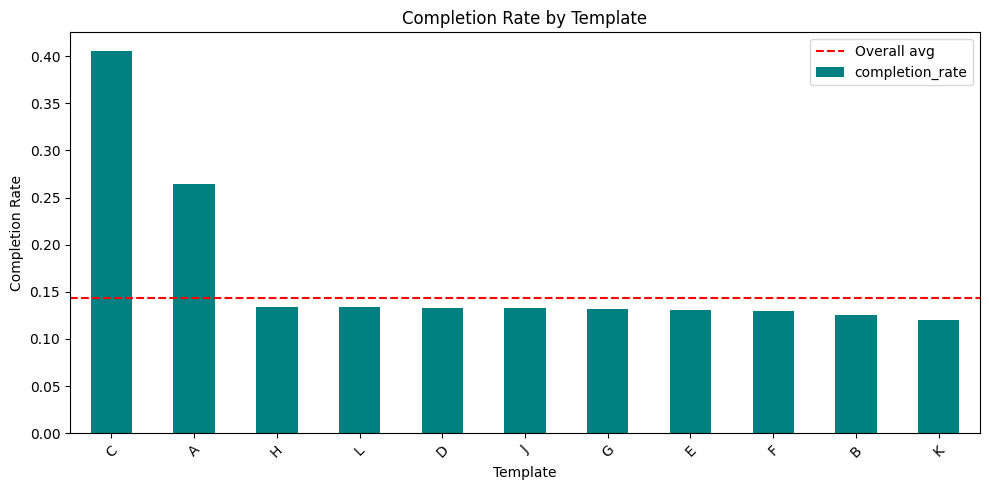

In [17]:
# Selected template distribution
print("\n\n=== SELECTED TEMPLATE DISTRIBUTION ===\n")
template_counts = df_train['selected_template'].value_counts()
print(f"Number of unique templates: {len(template_counts)}")
print(f"\nTemplate distribution:")
print(template_counts)

plt.figure(figsize=(10, 5))
template_counts.plot(kind='bar', color='coral')
plt.title('Selected Template Distribution')
plt.xlabel('Template')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# === COMPLETION RATE BY TEMPLATE ===
print("=== COMPLETION RATE BY TEMPLATE ===\n")

template_completion = (
    df_train.groupby('selected_template')['session_end_completed']
    .agg(total='count', completed='sum', completion_rate='mean')
    .sort_values('completion_rate', ascending=False)
)

print(template_completion)

plt.figure(figsize=(10, 5))
template_completion['completion_rate'].plot(kind='bar', color='teal')
plt.title('Completion Rate by Template')
plt.xlabel('Template')
plt.ylabel('Completion Rate')
plt.axhline(y=df_train['session_end_completed'].mean(), color='red', linestyle='--', label='Overall avg')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.Eligible Tempaltes (Numpy list -> Categorical)
1. number of eligible_templates counts
2. sucess rate vs. number of eligible_templates

=== ELIGIBLE TEMPLATES ANALYSIS ===

Distribution of eligible template counts:
num_eligible_templates
1       852
2        14
3        33
9     17459
10    11642
Name: count, dtype: int64


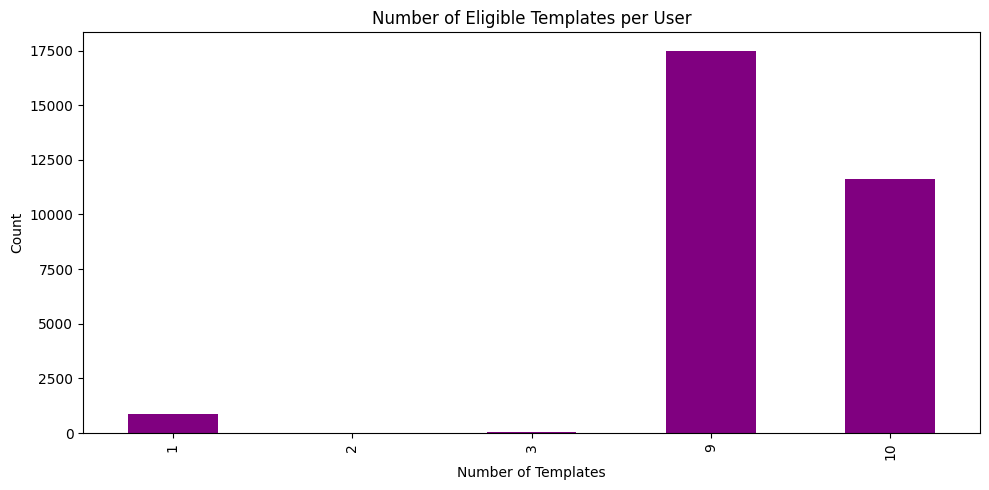


=== SUCCESS RATE BY NUMBER OF ELIGIBLE TEMPLATES ===

   num_eligible_templates  total  completed  success_rate
0                       1    852        345      0.404930
1                       2     14          2      0.142857
2                       3     33         15      0.454545
3                       9  17459        802      0.045936
4                      10  11642       3127      0.268596


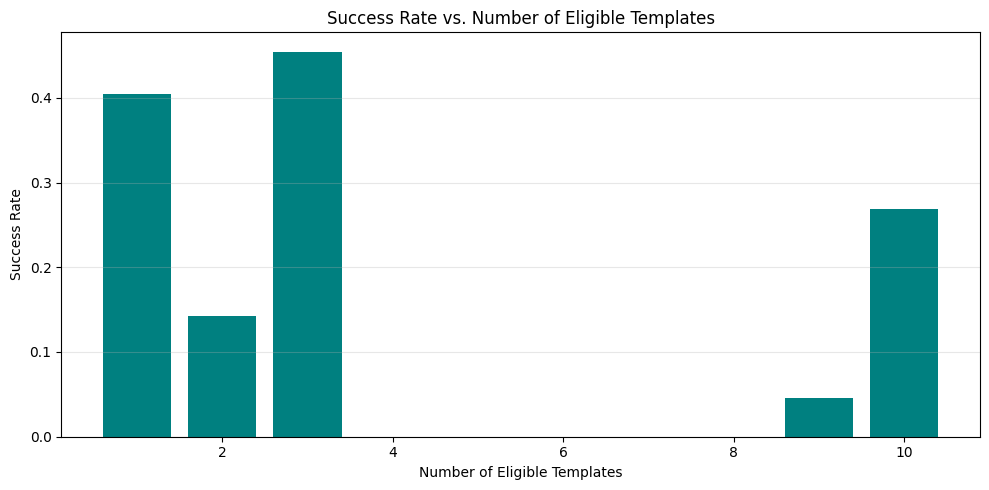

In [18]:
# Explore eligible_templates column (list of templates available)
print("=== ELIGIBLE TEMPLATES ANALYSIS ===\n")

# Convert numpy arrays to lists if needed
df_train['eligible_templates'] = df_train['eligible_templates'].apply(
    lambda x: list(x) if hasattr(x, '__iter__') and not isinstance(x, str) else []
)

# Number of eligible templates per row
df_train['num_eligible_templates'] = df_train['eligible_templates'].apply(len)
print(f"Distribution of eligible template counts:")
print(df_train['num_eligible_templates'].value_counts().sort_index())

plt.figure(figsize=(10, 5))
df_train['num_eligible_templates'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Number of Eligible Templates per User')
plt.xlabel('Number of Templates')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# === SUCCESS RATE vs. NUMBER OF ELIGIBLE TEMPLATES ===
print("\n=== SUCCESS RATE BY NUMBER OF ELIGIBLE TEMPLATES ===\n")

elig_success = (
    df_train.groupby('num_eligible_templates')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
    .sort_values('num_eligible_templates')
)

print(elig_success)

plt.figure(figsize=(10, 5))
plt.bar(elig_success['num_eligible_templates'], elig_success['success_rate'], color='teal')
plt.title('Success Rate vs. Number of Eligible Templates')
plt.xlabel('Number of Eligible Templates')
plt.ylabel('Success Rate')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


sample of eligible templates

In [19]:
# === SAMPLE ELIGIBLE TEMPLATES (FEW ROWS) ===
print("=== SAMPLE ELIGIBLE TEMPLATES (FEW ROWS) ===\n")

cols = ['datetime', 'ui_language', 'selected_template', 'eligible_templates', 'num_eligible_templates']
print(df_train[cols].tail(10))

=== SAMPLE ELIGIBLE TEMPLATES (FEW ROWS) ===

        datetime ui_language selected_template  \
29990   6.702234          ja                 G   
29991   7.446632          pl                 L   
29992  13.411759          zs                 L   
29993   6.497477          en                 F   
29994   2.333750          de                 G   
29995   0.857812          es                 B   
29996   8.637708          fr                 B   
29997  10.504722          es                 F   
29998  14.781817          es                 B   
29999   6.356655          es                 A   

                   eligible_templates  num_eligible_templates  
29990  [G, E, B, A, K, H, J, L, F, D]                      10  
29991     [G, E, B, K, H, J, L, F, D]                       9  
29992     [K, H, G, E, B, J, L, F, D]                       9  
29993     [G, E, B, K, H, J, L, F, D]                       9  
29994     [G, E, B, K, H, J, L, F, D]                       9  
29995  [G, E, B, A,

Interesting when there's only 1 tempalte eligible, its always C.

In [20]:
# === VERIFY: WHEN ONLY 1 TEMPLATE ELIGIBLE, IS IT ALMOST ALWAYS TEMPLATE C? ===
print("=== TEMPLATE C HYPOTHESIS: Single Eligible Template Analysis ===\n")

# Filter for cases with exactly 1 eligible template
single_elig = df_train[df_train['num_eligible_templates'] == 1]

print(f"Total rows with exactly 1 eligible template: {len(single_elig)}")
print(f"Percentage of total dataset: {len(single_elig) / len(df_train) * 100:.2f}%\n")

# Extract the single eligible template (should be a list with 1 element)
single_elig_template = single_elig['eligible_templates'].apply(lambda x: x[0] if len(x) > 0 else None)

print("Distribution of the single eligible template when num_eligible_templates == 1:")
print(single_elig_template.value_counts())
print(f"\nPercentage breakdown:")
print(single_elig_template.value_counts(normalize=True) * 100)

# Compare with what was actually selected
print("\n\nComparison: Eligible vs. Selected Template (when 1 eligible)")
comparison = pd.DataFrame({
    'eligible': single_elig_template,
    'selected': single_elig['selected_template'].values
})

print(f"\nWhen template C is the only eligible option:")
c_only = comparison[comparison['eligible'] == 'C']
print(f"  - Total cases: {len(c_only)}")
print(f"  - Was C selected? {(c_only['selected'] == 'C').sum()} times ({(c_only['selected'] == 'C').sum() / len(c_only) * 100:.1f}%)")
print(f"  - Something else selected? {(c_only['selected'] != 'C').sum()} times ({(c_only['selected'] != 'C').sum() / len(c_only) * 100:.1f}%)")
if (c_only['selected'] != 'C').sum() > 0:
    print(f"  - Other templates selected: {c_only[c_only['selected'] != 'C']['selected'].unique()}")

# Show a few sample rows
print("\n\nSample rows where only 1 template eligible:")
print(comparison.head(10))

=== TEMPLATE C HYPOTHESIS: Single Eligible Template Analysis ===

Total rows with exactly 1 eligible template: 852
Percentage of total dataset: 2.84%

Distribution of the single eligible template when num_eligible_templates == 1:
eligible_templates
C    852
Name: count, dtype: int64

Percentage breakdown:
eligible_templates
C    100.0
Name: proportion, dtype: float64


Comparison: Eligible vs. Selected Template (when 1 eligible)

When template C is the only eligible option:
  - Total cases: 852
  - Was C selected? 852 times (100.0%)
  - Something else selected? 0 times (0.0%)


Sample rows where only 1 template eligible:
    eligible selected
44         C        C
59         C        C
67         C        C
95         C        C
102        C        C
211        C        C
230        C        C
242        C        C
331        C        C
334        C        C


GOlD! What are all distinc eligible templates combo?

=== DISTINCT ELIGIBLE TEMPLATE COMBINATIONS ===

Total distinct combinations: 5

Combination frequencies (sorted by count):
eligible_templates
(B, D, E, F, G, H, J, K, L)       17459
(A, B, D, E, F, G, H, J, K, L)    11642
(C,)                                852
(A, H, K)                            33
(H, K)                               14
Name: count, dtype: int64


Detailed breakdown:
  [B, D, E, F, G, H, J, K, L]: 17459 rows (58.20%)
  [A, B, D, E, F, G, H, J, K, L]: 11642 rows (38.81%)
  [C]:   852 rows ( 2.84%)
  [A, H, K]:    33 rows ( 0.11%)
  [H, K]:    14 rows ( 0.05%)


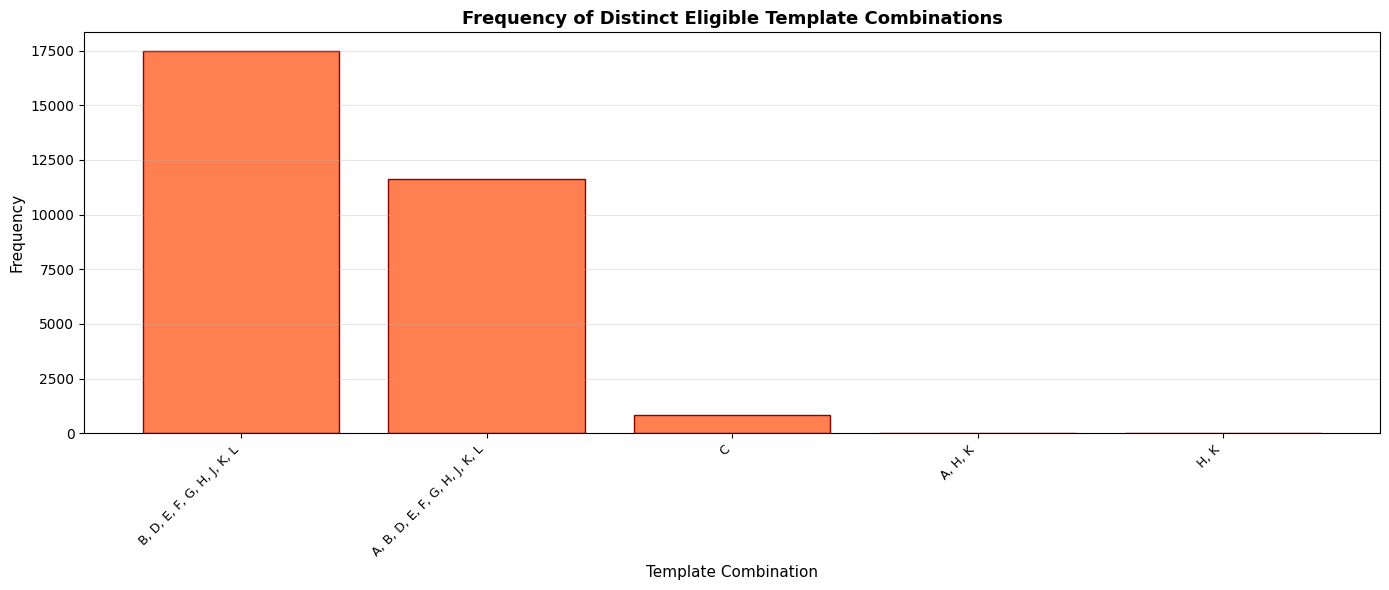


=== SUCCESS RATE BY DISTINCT ELIGIBLE TEMPLATE COMBINATION ===

                   eligible_combo  total  completed  success_rate  \
1                       (A, H, K)     33         15      0.454545   
3                            (C,)    852        345      0.404930   
0  (A, B, D, E, F, G, H, J, K, L)  11642       3127      0.268596   
4                          (H, K)     14          2      0.142857   
2     (B, D, E, F, G, H, J, K, L)  17459        802      0.045936   

                    combo_label  
1                       A, H, K  
3                             C  
0  A, B, D, E, F, G, H, J, K, L  
4                          H, K  
2     B, D, E, F, G, H, J, K, L  


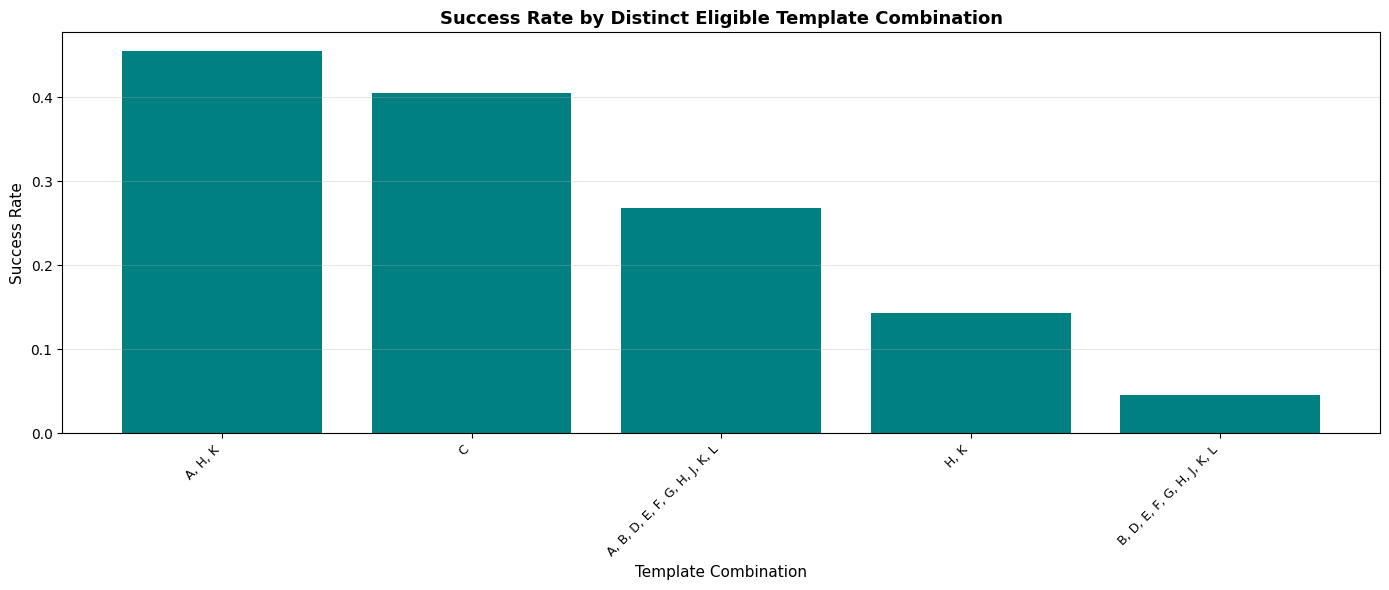

In [26]:
# === ALL DISTINCT ELIGIBLE TEMPLATE COMBINATIONS ===
print("=== DISTINCT ELIGIBLE TEMPLATE COMBINATIONS ===\n")

# Convert lists to tuples so they're hashable and can be counted
# Sort each combination for consistency (so [A,B] and [B,A] are treated the same)
eligible_combos = df_train['eligible_templates'].apply(lambda x: tuple(sorted(x)) if isinstance(x, list) else ())

# Get unique combinations and their frequencies
combo_counts = eligible_combos.value_counts().sort_values(ascending=False)

print(f"Total distinct combinations: {len(combo_counts)}\n")
print("Combination frequencies (sorted by count):")
print(combo_counts)

print(f"\n\nDetailed breakdown:")
for combo, count in combo_counts.items():
    pct = count / len(df_train) * 100
    combo_str = ', '.join(combo) if combo else '(empty)'
    print(f"  [{combo_str}]: {count:5d} rows ({pct:5.2f}%)")

# Create a dataframe for visualization
combo_df = pd.DataFrame({
    'Combination': [', '.join(c) if c else '(empty)' for c in combo_counts.index],
    'Frequency': combo_counts.values
}).reset_index(drop=True)

# Bar chart
plt.figure(figsize=(14, 6))
plt.bar(range(len(combo_df)), combo_df['Frequency'], color='coral', edgecolor='darkred')
plt.xticks(range(len(combo_df)), combo_df['Combination'], rotation=45, ha='right', fontsize=9)
plt.xlabel('Template Combination', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Frequency of Distinct Eligible Template Combinations', fontsize=13, fontweight='bold')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# === SUCCESS RATE BY DISTINCT ELIGIBLE TEMPLATE COMBINATION ===
print("\n=== SUCCESS RATE BY DISTINCT ELIGIBLE TEMPLATE COMBINATION ===\n")

combo_success = (
    df_train.assign(eligible_combo=eligible_combos)
    .groupby('eligible_combo')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
    .sort_values('success_rate', ascending=False)
)

combo_success['combo_label'] = combo_success['eligible_combo'].apply(
    lambda c: ', '.join(c) if c else '(empty)'
)

print(combo_success)

plt.figure(figsize=(14, 6))
plt.bar(combo_success['combo_label'], combo_success['success_rate'], color='teal')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.xlabel('Template Combination', fontsize=11)
plt.ylabel('Success Rate', fontsize=11)
plt.title('Success Rate by Distinct Eligible Template Combination', fontsize=13, fontweight='bold')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Individual templates frequency count

=== INDIVIDUAL TEMPLATE FREQUENCIES ===

Template frequency count:
   Template  Frequency
0         K      29148
1         H      29148
2         G      29101
3         E      29101
4         B      29101
5         J      29101
6         L      29101
7         F      29101
8         D      29101
9         A      11675
10        C        852


Detailed breakdown:
  Template K: 29148 occurrences (10.62%)
  Template H: 29148 occurrences (10.62%)
  Template G: 29101 occurrences (10.60%)
  Template E: 29101 occurrences (10.60%)
  Template B: 29101 occurrences (10.60%)
  Template J: 29101 occurrences (10.60%)
  Template L: 29101 occurrences (10.60%)
  Template F: 29101 occurrences (10.60%)
  Template D: 29101 occurrences (10.60%)
  Template A: 11675 occurrences ( 4.25%)
  Template C:   852 occurrences ( 0.31%)


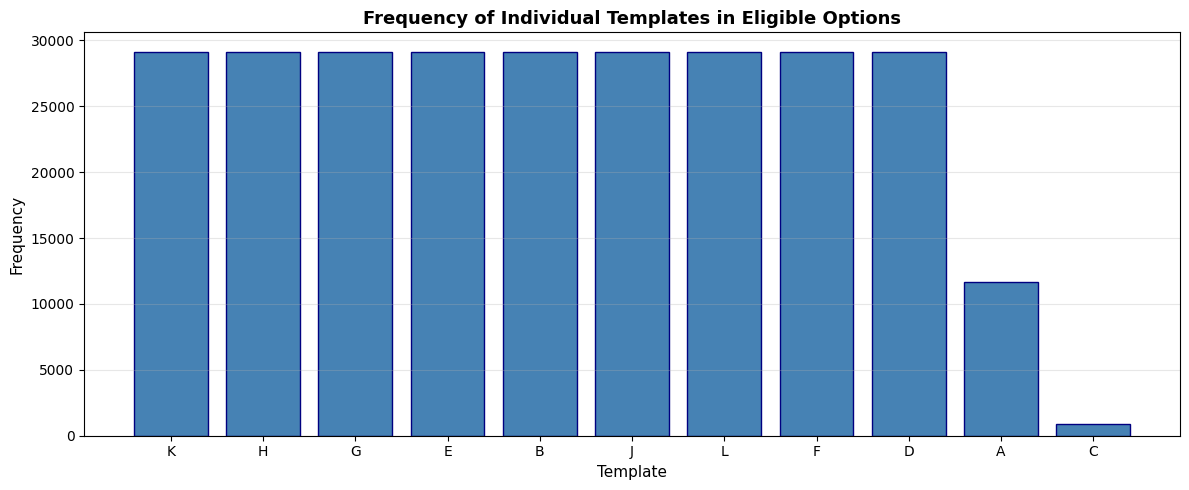

In [ ]:
# === ALL INDIVIDUAL TEMPLATES - FREQUENCY COUNT ===
print("=== INDIVIDUAL TEMPLATE FREQUENCIES ===\n")

# Flatten all templates from all combinations
all_templates = []
for templates_list in df_train['eligible_templates']:
    if isinstance(templates_list, list):
        all_templates.extend(templates_list)

# Count frequencies
from collections import Counter
template_freq = Counter(all_templates)
template_freq_df = pd.DataFrame(
    sorted(template_freq.items(), key=lambda x: x[1], reverse=True),
    columns=['Template', 'Frequency']
)

print("Template frequency count:")
print(template_freq_df)

print(f"\n\nDetailed breakdown:")
total_template_slots = sum(template_freq.values())
for _, row in template_freq_df.iterrows():
    pct = row['Frequency'] / total_template_slots * 100
    print(f"  Template {row['Template']}: {row['Frequency']:5d} occurrences ({pct:5.2f}%)")

# Visualize
plt.figure(figsize=(12, 5))
plt.bar(template_freq_df['Template'], template_freq_df['Frequency'], color='steelblue', edgecolor='navy')
plt.title('Frequency of Individual Templates in Eligible Options', fontsize=13, fontweight='bold')
plt.xlabel('Template', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



Making eligible tempalte as a categorical variables with 5 different levels

=== ELIGIBLE TEMPLATE COMBOS AS CATEGORICAL VARIABLE ===

Mapping of combinations to categorical levels:
  Level 1: ('B', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L') - 17459 rows (58.20%)
  Level 2: ('A', 'B', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L') - 11642 rows (38.81%)
  Level 3: ('C',) -   852 rows ( 2.84%)
  Level 4: ('A', 'H', 'K') -    33 rows ( 0.11%)
  Level 5: ('H', 'K') -    14 rows ( 0.05%)


Categorical distribution:
eligible_templates_category
1    17459
2    11642
3      852
4       33
5       14
Name: count, dtype: int64


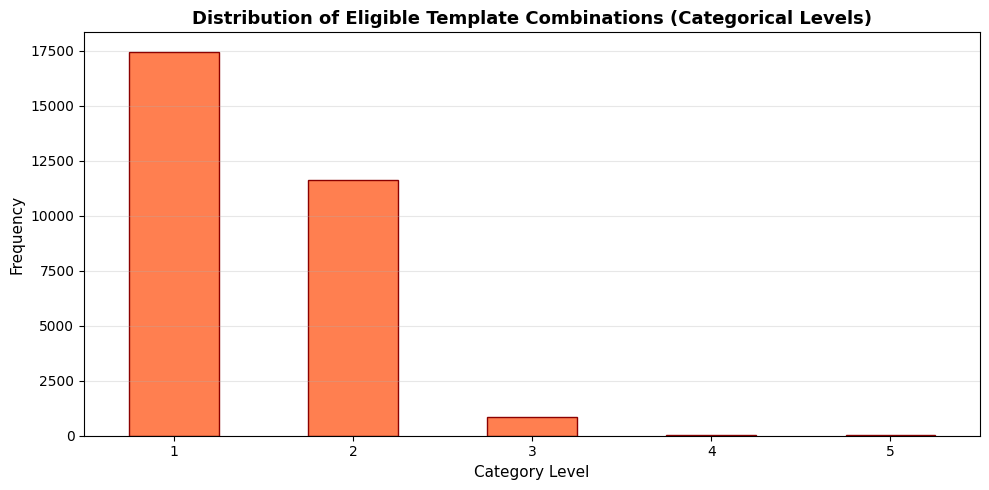



Data type: category
Categories: [1, 2, 3, 4, 5]


In [23]:
# === CONVERT ELIGIBLE TEMPLATE COMBINATIONS TO CATEGORICAL VARIABLE ===
print("=== ELIGIBLE TEMPLATE COMBOS AS CATEGORICAL VARIABLE ===\n")

# Create a mapping of each distinct combination to a category level
eligible_combos_sorted = df_train['eligible_templates'].apply(lambda x: tuple(sorted(x)) if isinstance(x, list) else ())
unique_combos = eligible_combos_sorted.unique()

# Sort by frequency to assign levels (most frequent = level 1)
combo_freq = eligible_combos_sorted.value_counts()
combo_to_level = {combo: level for level, (combo, _) in enumerate(combo_freq.items(), start=1)}

print(f"Mapping of combinations to categorical levels:")
for combo, level in sorted(combo_to_level.items(), key=lambda x: x[1]):
    count = combo_freq[combo]
    pct = count / len(df_train) * 100
    print(f"  Level {level}: {combo} - {count:5d} rows ({pct:5.2f}%)")

# Create the categorical column
df_train['eligible_templates_category'] = eligible_combos_sorted.map(combo_to_level).astype('category')

print(f"\n\nCategorical distribution:")
print(df_train['eligible_templates_category'].value_counts().sort_index())

# Visualize
plt.figure(figsize=(10, 5))
df_train['eligible_templates_category'].value_counts().sort_index().plot(kind='bar', color='coral', edgecolor='darkred')
plt.title('Distribution of Eligible Template Combinations (Categorical Levels)', fontsize=13, fontweight='bold')
plt.xlabel('Category Level', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.xticks(rotation=0)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n\nData type: {df_train['eligible_templates_category'].dtype}")
print(f"Categories: {df_train['eligible_templates_category'].cat.categories.tolist()}")


=== SUCCESS RATE BY ELIGIBLE TEMPLATE CATEGORY LEVEL ===

  eligible_templates_category  total  completed  success_rate
0                           1  17459        802      0.045936
1                           2  11642       3127      0.268596
2                           3    852        345      0.404930
3                           4     33         15      0.454545
4                           5     14          2      0.142857


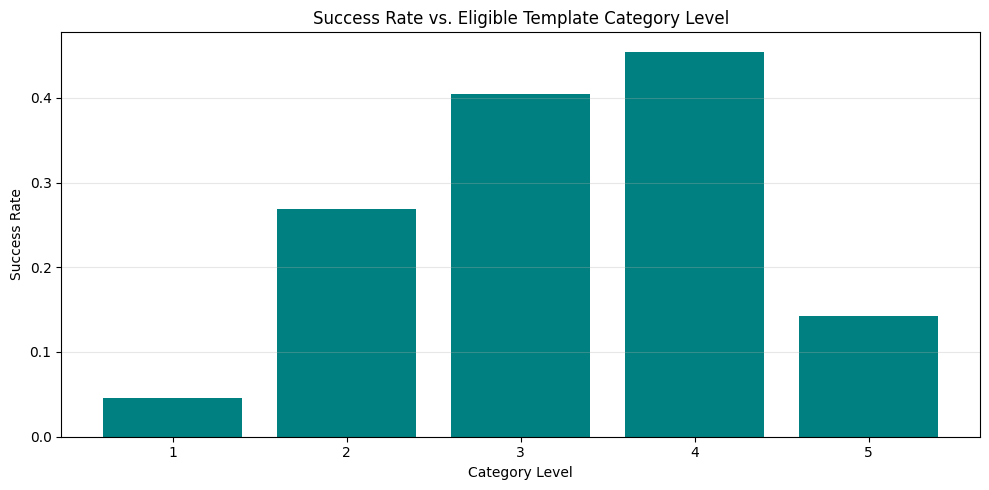

In [24]:
# === SUCCESS RATE vs. CATEGORY LEVEL ===
print("=== SUCCESS RATE BY ELIGIBLE TEMPLATE CATEGORY LEVEL ===\n")

cat_success = (
    df_train.groupby('eligible_templates_category')['session_end_completed']
    .agg(total='count', completed='sum', success_rate='mean')
    .reset_index()
    .sort_values('eligible_templates_category')
)

print(cat_success)

plt.figure(figsize=(10, 5))
plt.bar(cat_success['eligible_templates_category'].astype(str), cat_success['success_rate'], color='teal')
plt.title('Success Rate vs. Eligible Template Category Level')
plt.xlabel('Category Level')
plt.ylabel('Success Rate')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 7. History (Numpy List)

=== SAMPLE HISTORY (FEW ROWS) ===

    datetime ui_language selected_template  \
0   3.149062          en                 H   
1  11.205116          en                 J   
2   1.327755          it                 A   
3   9.309120          ko                 G   
4   2.675671          en                 L   

                                             history  
0  [{'template': 'F', 'n_days': 6.234179496765137...  
1  [{'template': 'G', 'n_days': 29.0074405670166}...  
2  [{'template': 'G', 'n_days': 29.00708389282226...  
3  [{'template': 'J', 'n_days': 18.86638450622558...  
4  [{'template': 'B', 'n_days': 29.83049964904785...  

History length summary (first 5 rows):
Row 0: history_len=3
Row 1: history_len=18
Row 2: history_len=12
Row 3: history_len=8
Row 4: history_len=7


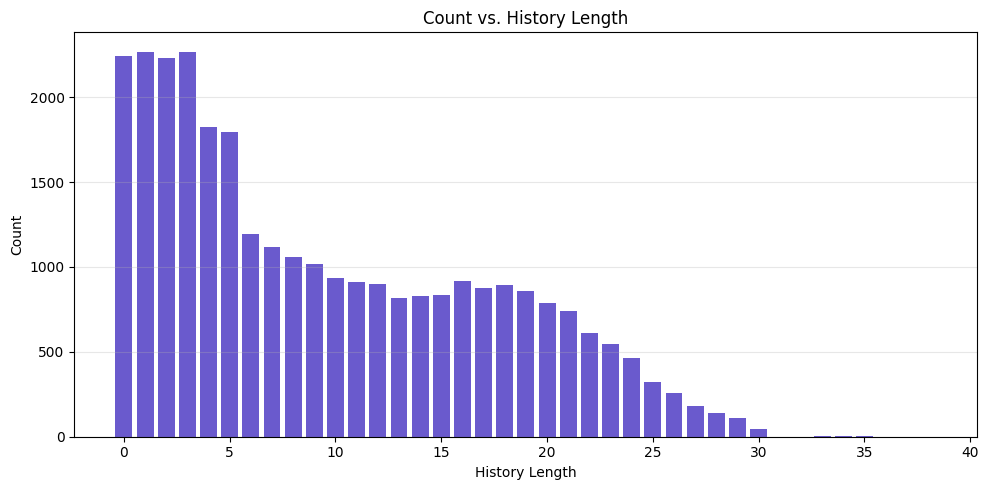

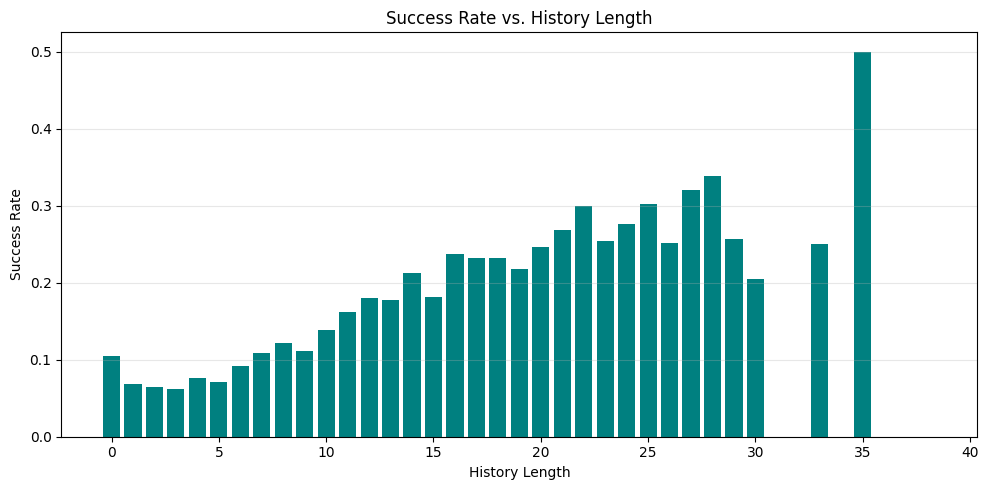

In [29]:
# === SAMPLE HISTORY (FEW ROWS) ===
print("=== SAMPLE HISTORY (FEW ROWS) ===\n")

history_cols = ['datetime', 'ui_language', 'selected_template', 'history']
print(df_train[history_cols].head(5))

# If history is list/array-like, show lengths for quick inspection
if 'history' in df_train.columns:
    print("\nHistory length summary (first 5 rows):")
    for i, row in df_train[history_cols].head(5).iterrows():
        hist = row['history']
        length = len(hist) if hasattr(hist, '__len__') and not isinstance(hist, str) else 'N/A'
        print(f"Row {i}: history_len={length}")

    # === COUNT vs. HISTORY LENGTH ===
    df_train['history_len'] = df_train['history'].apply(
        lambda x: len(x) if hasattr(x, '__len__') and not isinstance(x, str) else 0
    )

    history_counts = (
        df_train.groupby('history_len')
        .size()
        .reset_index(name='count')
        .sort_values('history_len')
    )

    plt.figure(figsize=(10, 5))
    plt.bar(history_counts['history_len'], history_counts['count'], color='slateblue')
    plt.title('Count vs. History Length')
    plt.xlabel('History Length')
    plt.ylabel('Count')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # === SUCCESS RATE vs. HISTORY LENGTH ===
    history_success = (
        df_train.groupby('history_len')['session_end_completed']
        .agg(total='count', completed='sum', success_rate='mean')
        .reset_index()
        .sort_values('history_len')
    )

    plt.figure(figsize=(10, 5))
    plt.bar(history_success['history_len'], history_success['success_rate'], color='teal')
    plt.title('Success Rate vs. History Length')
    plt.xlabel('History Length')
    plt.ylabel('Success Rate')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [36]:
# === ROWS WHERE EACH TEMPLATE APPEARS IN HISTORY ===
print("=== ANALYZING ALL TEMPLATES IN HISTORY ===\n")

# First, extract all unique templates from history
all_templates_in_history = set()
for hist in df_train['history']:
    if hasattr(hist, '__iter__') and not isinstance(hist, str):
        for item in hist:
            if isinstance(item, dict) and 'template' in item:
                all_templates_in_history.add(item['template'])

print(f"Unique templates found in history: {sorted(all_templates_in_history)}\n")

# Now analyze each template
for template in sorted(all_templates_in_history):
    print(f"\n{'='*60}")
    print(f"TEMPLATE {template}")
    print('='*60)
    
    # Identify rows where history contains this template
    has_template = df_train['history'].apply(
        lambda x: any(isinstance(item, dict) and item.get('template') == template for item in x)
        if hasattr(x, '__iter__') and not isinstance(x, str) else False
    )
    
    rows_with_template = df_train.loc[has_template, ['datetime', 'ui_language', 'selected_template', 'history', 'session_end_completed']]
    print(f"Total rows with '{template}' in history: {len(rows_with_template)}")
    
    if len(rows_with_template) > 0:
        # Calculate success rate
        success_rate = rows_with_template['session_end_completed'].mean()
        print(f"Success rate for rows with '{template}' in history: {success_rate:.4f}")
        
        # Show sample rows
        print(f"\nSample rows (first 5):")
        print(rows_with_template.head(5))
    else:
        print("No rows found with this template in history.")


=== ANALYZING ALL TEMPLATES IN HISTORY ===

Unique templates found in history: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


TEMPLATE A
Total rows with 'A' in history: 12288
Success rate for rows with 'A' in history: 0.2239

Sample rows (first 5):
    datetime ui_language selected_template  \
4   2.675671          en                 L   
7   3.012604          it                 E   
8   8.220150          ru                 K   
9   6.760729          en                 H   
15  9.642338          es                 K   

                                              history  session_end_completed  
4   [{'template': 'B', 'n_days': 29.83049964904785...                  False  
7   [{'template': 'G', 'n_days': 29.01489639282226...                  False  
8   [{'template': 'A', 'n_days': 27.97650909423828...                  False  
9   [{'template': 'A', 'n_days': 25.19981193542480...                  False  
15  [{'template': 'B', 'n_days': 29.95262718200683...          

=== TEMPLATE FREQUENCY IN HISTORY (ACROSS ALL ROWS) ===

Template counts in history:
   Template  Count
0         B  40899
1         E  40776
2         G  40551
3         A  22833
4         H  21363
5         F  21312
6         L  21208
7         K  21083
8         D  20981
9         J  20940
10        C  14108
11        I    153

Total template entries in history: 286207

Percentage breakdown:
  Template B: 40,899 (14.29%)
  Template E: 40,776 (14.25%)
  Template G: 40,551 (14.17%)
  Template A: 22,833 (7.98%)
  Template H: 21,363 (7.46%)
  Template F: 21,312 (7.45%)
  Template L: 21,208 (7.41%)
  Template K: 21,083 (7.37%)
  Template D: 20,981 (7.33%)
  Template J: 20,940 (7.32%)
  Template C: 14,108 (4.93%)
  Template I: 153 (0.05%)


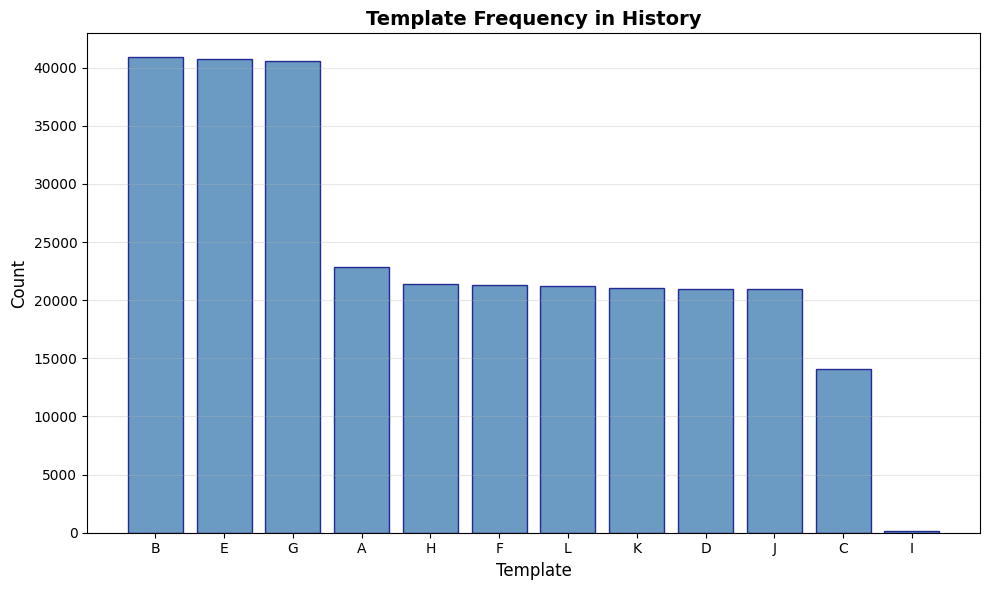

In [37]:
# === TEMPLATE COUNT IN HISTORY - VISUALIZATION ===
print("=== TEMPLATE FREQUENCY IN HISTORY (ACROSS ALL ROWS) ===\n")

# Count occurrences of each template across all history entries
from collections import Counter
template_counter = Counter()

for hist in df_train['history']:
    if hasattr(hist, '__iter__') and not isinstance(hist, str):
        for item in hist:
            if isinstance(item, dict) and 'template' in item:
                template_counter[item['template']] += 1

# Convert to dataframe for easier plotting
template_counts_hist = pd.DataFrame(
    sorted(template_counter.items(), key=lambda x: x[1], reverse=True),
    columns=['Template', 'Count']
)

print("Template counts in history:")
print(template_counts_hist)

# Calculate percentages
total_history_entries = sum(template_counter.values())
print(f"\nTotal template entries in history: {total_history_entries}")
print("\nPercentage breakdown:")
for _, row in template_counts_hist.iterrows():
    pct = (row['Count'] / total_history_entries) * 100
    print(f"  Template {row['Template']}: {row['Count']:,} ({pct:.2f}%)")

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(template_counts_hist['Template'], template_counts_hist['Count'], 
        color='steelblue', edgecolor='navy', alpha=0.8)
plt.title('Template Frequency in History', fontsize=14, fontweight='bold')
plt.xlabel('Template', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


=== ANALYZING n_days DISTRIBUTION BY TEMPLATE ===

n_days represents days since the template was sent (higher = older/earlier)
Lower n_days = more recent, Higher n_days = earlier in user's history

Total template-n_days pairs extracted: 286207

n_days statistics by template (sorted by mean):
          count       mean     median       std        min        max
template                                                             
I           153  22.800622  22.999092  4.547952  12.339304  29.989393
A         22833  15.938908  17.003571  8.970306   0.218217  29.999804
B         40899  15.638685  16.882414  9.247894   0.003469  29.999926
G         40551  15.601709  16.858545  9.237918   0.003467  29.999763
E         40776  15.472653  16.563547  9.235842   0.099291  29.999918
C         14108  14.275664  13.980082  8.464063   0.369866  29.999645
K         21083   8.439736   7.000002  6.350500   0.003471  29.995960
H         21363   8.439687   7.004966  6.269235   0.003465  29.998615
D      

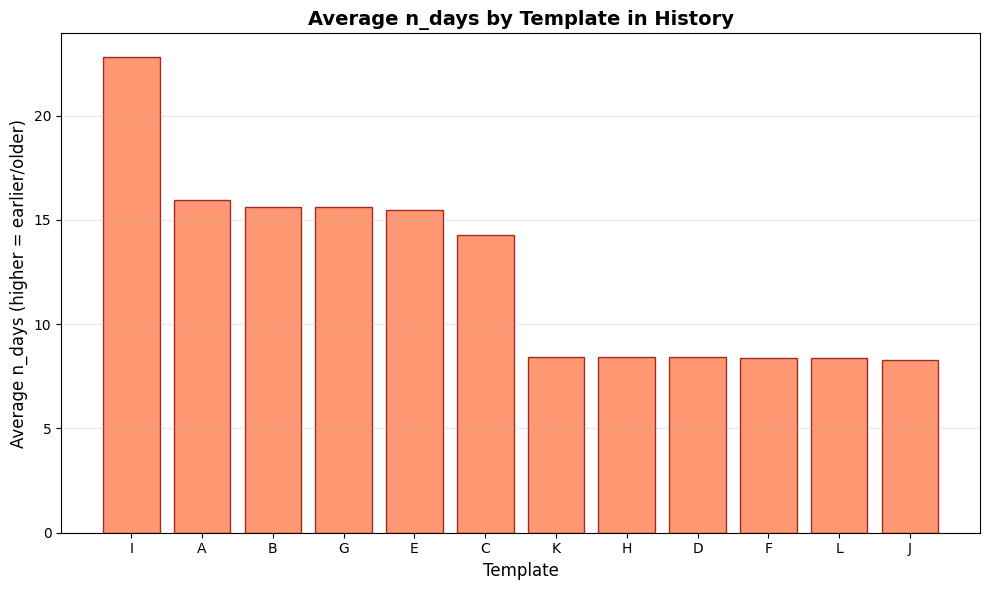

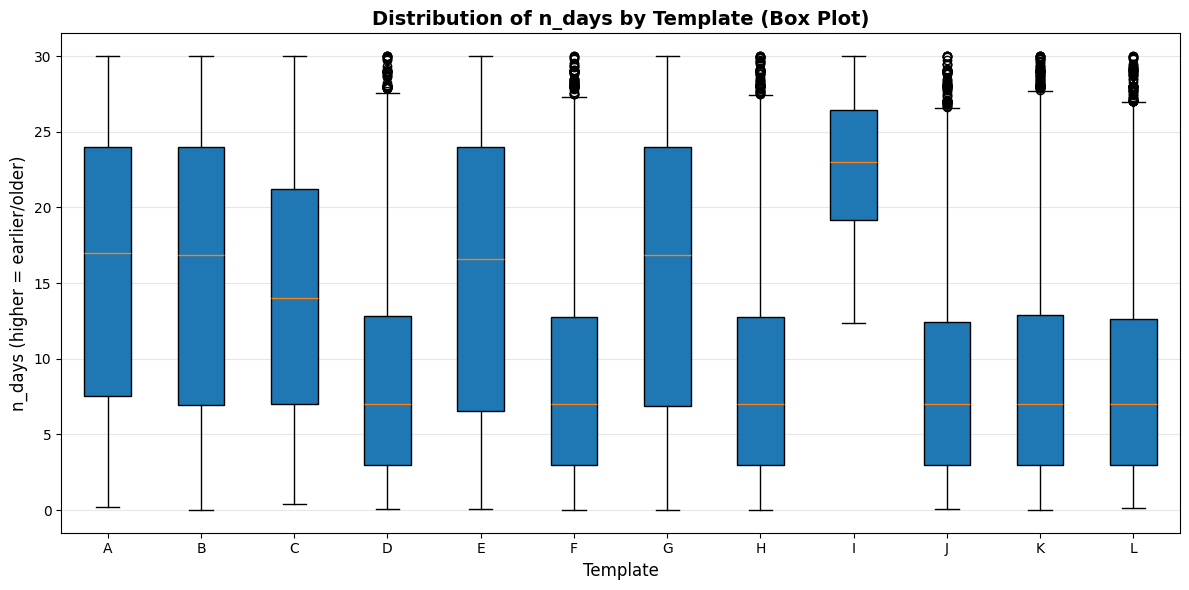

In [38]:
# === TEMPORAL TREND: n_days BY TEMPLATE IN HISTORY ===
print("=== ANALYZING n_days DISTRIBUTION BY TEMPLATE ===\n")
print("n_days represents days since the template was sent (higher = older/earlier)")
print("Lower n_days = more recent, Higher n_days = earlier in user's history\n")

# Extract all template-n_days pairs from history
template_ndays_list = []
for hist in df_train['history']:
    if hasattr(hist, '__iter__') and not isinstance(hist, str):
        for item in hist:
            if isinstance(item, dict) and 'template' in item and 'n_days' in item:
                template_ndays_list.append({
                    'template': item['template'],
                    'n_days': item['n_days']
                })

# Convert to dataframe
template_ndays_df = pd.DataFrame(template_ndays_list)

if len(template_ndays_df) > 0:
    print(f"Total template-n_days pairs extracted: {len(template_ndays_df)}\n")
    
    # Summary statistics by template
    ndays_stats = template_ndays_df.groupby('template')['n_days'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).sort_values('mean', ascending=False)
    
    print("n_days statistics by template (sorted by mean):")
    print(ndays_stats)
    print("\nInterpretation:")
    print("  - Higher mean/median = template appears earlier in user history (older)")
    print("  - Lower mean/median = template appears more recently in user history (newer)")
    
    # Visualize mean n_days by template
    plt.figure(figsize=(10, 6))
    templates_sorted = ndays_stats.sort_values('mean', ascending=False).index
    means = [ndays_stats.loc[t, 'mean'] for t in templates_sorted]
    
    plt.bar(templates_sorted, means, color='coral', edgecolor='darkred', alpha=0.8)
    plt.title('Average n_days by Template in History', fontsize=14, fontweight='bold')
    plt.xlabel('Template', fontsize=12)
    plt.ylabel('Average n_days (higher = earlier/older)', fontsize=12)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Box plot to show distribution
    plt.figure(figsize=(12, 6))
    templates_for_box = sorted(template_ndays_df['template'].unique())
    data_for_box = [template_ndays_df[template_ndays_df['template'] == t]['n_days'].values 
                    for t in templates_for_box]
    
    plt.boxplot(data_for_box, labels=templates_for_box, patch_artist=True)
    plt.title('Distribution of n_days by Template (Box Plot)', fontsize=14, fontweight='bold')
    plt.xlabel('Template', fontsize=12)
    plt.ylabel('n_days (higher = earlier/older)', fontsize=12)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("No template-n_days pairs found in history.")


=== TEMPLATE C ANALYSIS: User Type Characterization ===

Total rows with template C in history: 3481
Total rows without template C: 26519

=== USER CHARACTERIZATION FOR TEMPLATE C ===

Average n_days when template C appears: 13.07 days
Median n_days when template C appears: 13.51 days
Std dev: 7.04 days

=== USER TYPE DISTRIBUTION ===
c_user_type
Established (10-20 days)    1752
Recent/New (0-10 days)      1192
Early/Old (20+ days)         537
Name: count, dtype: int64

=== ACTIVITY LEVEL ANALYSIS ===
History length as proxy for user engagement:
                          count       mean  median       std
c_user_type                                                 
Recent/New (0-10 days)     1192  10.064597     9.0  6.403192
Established (10-20 days)   1752  17.248858    17.0  5.861016
Early/Old (20+ days)        537  16.983240    18.0  5.576946


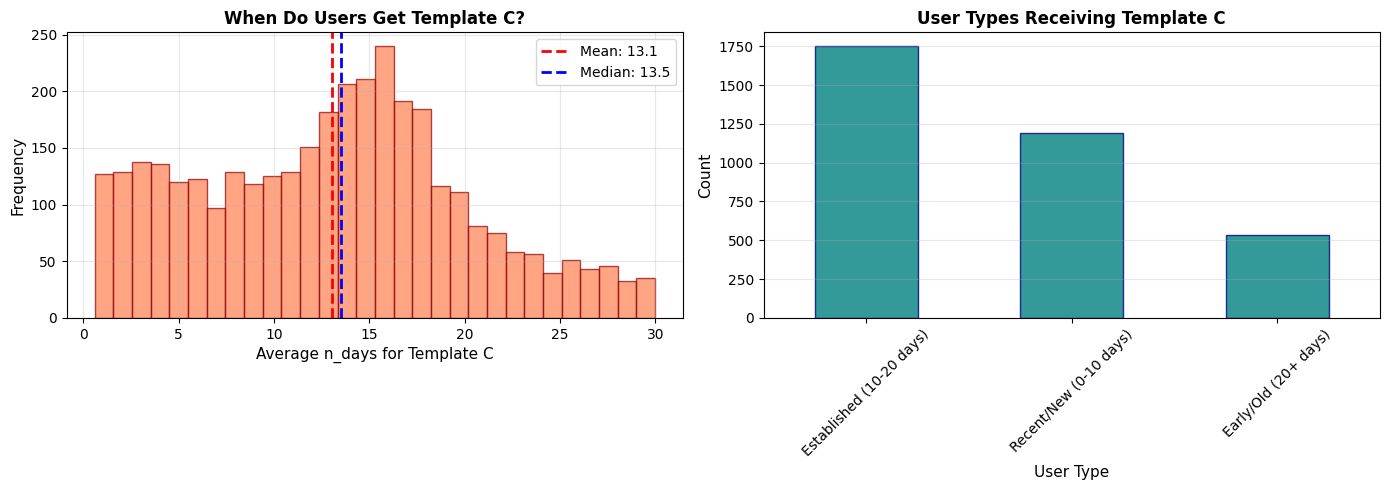


=== SUCCESS RATE BY USER TYPE ===
                          count  sum  success_rate
c_user_type                                       
Recent/New (0-10 days)     1192  279      0.234060
Established (10-20 days)   1752  576      0.328767
Early/Old (20+ days)        537  131      0.243948


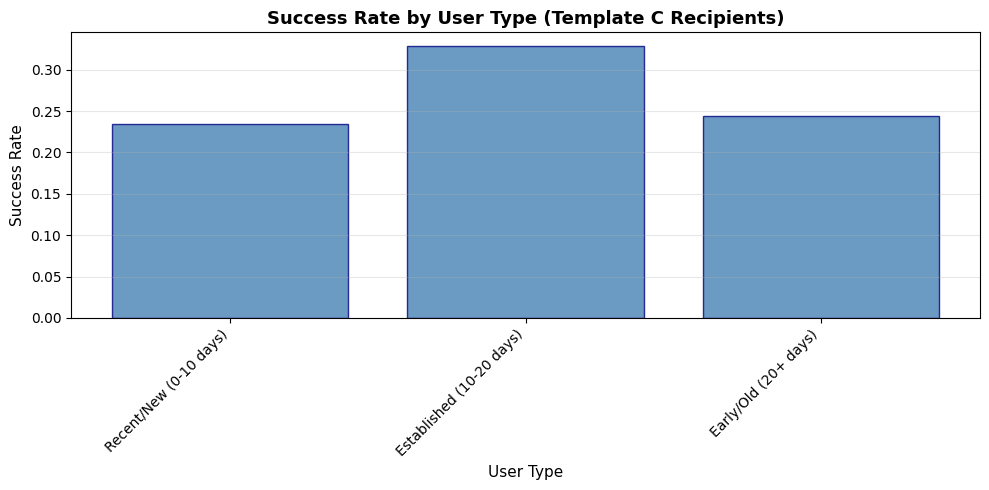

In [39]:
# === DEEP DIVE: TEMPLATE C - WHO GETS IT? NEW vs OLD vs ACTIVE USERS ===
print("=== TEMPLATE C ANALYSIS: User Type Characterization ===\n")

# For each row, check if template C appears in history and extract its n_days
def get_template_c_ndays(hist):
    """Extract n_days values for template C from history"""
    c_ndays = []
    if hasattr(hist, '__iter__') and not isinstance(hist, str):
        for item in hist:
            if isinstance(item, dict) and item.get('template') == 'C' and 'n_days' in item:
                c_ndays.append(item['n_days'])
    return c_ndays

df_train['has_template_c'] = df_train['history'].apply(
    lambda x: any(isinstance(item, dict) and item.get('template') == 'C' for item in x)
    if hasattr(x, '__iter__') and not isinstance(x, str) else False
)

df_train['template_c_ndays'] = df_train['history'].apply(get_template_c_ndays)
df_train['template_c_avg_ndays'] = df_train['template_c_ndays'].apply(
    lambda x: np.mean(x) if len(x) > 0 else np.nan
)
df_train['template_c_count_in_history'] = df_train['template_c_ndays'].apply(len)

# Characterize users with template C
rows_with_c = df_train[df_train['has_template_c']].copy()

print(f"Total rows with template C in history: {len(rows_with_c)}")
print(f"Total rows without template C: {len(df_train) - len(rows_with_c)}\n")

if len(rows_with_c) > 0:
    # User characterization based on n_days distribution
    # Higher avg n_days = older users (C appeared earlier)
    # Lower avg n_days = newer/more active users (C appeared recently)
    
    print("=== USER CHARACTERIZATION FOR TEMPLATE C ===")
    print(f"\nAverage n_days when template C appears: {rows_with_c['template_c_avg_ndays'].mean():.2f} days")
    print(f"Median n_days when template C appears: {rows_with_c['template_c_avg_ndays'].median():.2f} days")
    print(f"Std dev: {rows_with_c['template_c_avg_ndays'].std():.2f} days")
    
    # Categorize users by when they received template C
    # Low n_days (0-10) = recent/new users
    # Medium n_days (10-20) = established users  
    # High n_days (20+) = old/early users
    
    rows_with_c['c_user_type'] = pd.cut(
        rows_with_c['template_c_avg_ndays'],
        bins=[0, 10, 20, float('inf')],
        labels=['Recent/New (0-10 days)', 'Established (10-20 days)', 'Early/Old (20+ days)']
    )
    
    print("\n=== USER TYPE DISTRIBUTION ===")
    user_type_counts = rows_with_c['c_user_type'].value_counts()
    print(user_type_counts)
    
    # Compare with history length (proxy for user activity)
    print("\n=== ACTIVITY LEVEL ANALYSIS ===")
    print("History length as proxy for user engagement:")
    activity_stats = rows_with_c.groupby('c_user_type')['history_len'].agg([
        'count', 'mean', 'median', 'std'
    ])
    print(activity_stats)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Distribution of n_days for template C
    axes[0].hist(rows_with_c['template_c_avg_ndays'].dropna(), bins=30, 
                 color='coral', edgecolor='darkred', alpha=0.7)
    axes[0].axvline(rows_with_c['template_c_avg_ndays'].mean(), 
                    color='red', linestyle='--', linewidth=2, label=f"Mean: {rows_with_c['template_c_avg_ndays'].mean():.1f}")
    axes[0].axvline(rows_with_c['template_c_avg_ndays'].median(), 
                    color='blue', linestyle='--', linewidth=2, label=f"Median: {rows_with_c['template_c_avg_ndays'].median():.1f}")
    axes[0].set_xlabel('Average n_days for Template C', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('When Do Users Get Template C?', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: User type distribution
    user_type_counts.plot(kind='bar', ax=axes[1], color='teal', edgecolor='navy', alpha=0.8)
    axes[1].set_xlabel('User Type', fontsize=11)
    axes[1].set_ylabel('Count', fontsize=11)
    axes[1].set_title('User Types Receiving Template C', fontsize=12, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Success rate by user type
    print("\n=== SUCCESS RATE BY USER TYPE ===")
    success_by_type = rows_with_c.groupby('c_user_type')['session_end_completed'].agg([
        'count', 'sum', 'mean'
    ]).rename(columns={'mean': 'success_rate'})
    print(success_by_type)
    
    plt.figure(figsize=(10, 5))
    plt.bar(success_by_type.index.astype(str), success_by_type['success_rate'], 
            color='steelblue', edgecolor='navy', alpha=0.8)
    plt.title('Success Rate by User Type (Template C Recipients)', fontsize=13, fontweight='bold')
    plt.xlabel('User Type', fontsize=11)
    plt.ylabel('Success Rate', fontsize=11)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("No rows with template C in history found.")


### IV. Feature Engineering

In [40]:
# === FEATURE ENGINEERING FOR LOGISTIC REGRESSION ===
print("=== FEATURE ENGINEERING ===\n")

# Selected features based on EDA:
# 1. Temporal: hour, dow_proxy, day_index
# 2. Template: selected_template (categorical)
# 3. Eligible templates: eligible_templates_category (categorical)
# 4. User engagement: history_len
# 5. Locale: ui_language (categorical)

# Create a copy of the dataframe for modeling
df_model = df_train.copy()

# 1. Numeric features (use as-is)
numeric_features = ['hour', 'dow_proxy', 'day_index', 'history_len']

print("=== NUMERIC FEATURES ===")
print(f"Features: {numeric_features}")
print(f"\nSummary statistics:")
print(df_model[numeric_features].describe())

# 2. Categorical features (need encoding)
categorical_features = ['selected_template', 'eligible_templates_category', 'ui_language']

print(f"\n\n=== CATEGORICAL FEATURES ===")
print(f"Features: {categorical_features}")

for feat in categorical_features:
    print(f"\n{feat}:")
    print(f"  - Unique values: {df_model[feat].nunique()}")
    print(f"  - Top 5: {df_model[feat].value_counts().head().to_dict()}")

# 3. One-hot encode categorical features
print(f"\n\n=== ONE-HOT ENCODING ===")

# Convert eligible_templates_category to string for encoding
df_model['eligible_templates_category'] = df_model['eligible_templates_category'].astype(str)

# Perform one-hot encoding
df_encoded = pd.get_dummies(
    df_model[numeric_features + categorical_features],
    columns=categorical_features,
    drop_first=True  # Drop first category to avoid multicollinearity
)

print(f"Original features: {len(numeric_features + categorical_features)}")
print(f"Encoded features: {len(df_encoded.columns)}")
print(f"\nEncoded feature names:")
for i, col in enumerate(df_encoded.columns, 1):
    print(f"  {i}. {col}")

# 4. Prepare X (features) and y (target)
X = df_encoded
y = df_model['session_end_completed'].astype(int)

print(f"\n\n=== FINAL DATASET FOR MODELING ===")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"\nTarget rate: {y.mean():.4f}")

# 5. Check for missing values
print(f"\n\n=== DATA QUALITY CHECK ===")
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print("WARNING: Missing values detected:")
    print(missing_counts[missing_counts > 0])
else:
    print("✓ No missing values in feature set")

# 6. Summary
print(f"\n\n=== FEATURE SUMMARY ===")
print(f"Total observations: {len(X):,}")
print(f"Total features: {len(X.columns)}")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Encoded categorical features: {len(X.columns) - len(numeric_features)}")
print(f"\nFeature breakdown:")
print(f"  - Temporal: hour, dow_proxy, day_index")
print(f"  - Template: selected_template (one-hot encoded)")
print(f"  - Eligible combinations: eligible_templates_category (one-hot encoded)")
print(f"  - User engagement: history_len")
print(f"  - Locale: ui_language (one-hot encoded)")

print("\n✓ Feature engineering complete. Ready for model training!")


=== FEATURE ENGINEERING ===

=== NUMERIC FEATURES ===
Features: ['hour', 'dow_proxy', 'day_index', 'history_len']

Summary statistics:
               hour     dow_proxy     day_index   history_len
count  30000.000000  30000.000000  30000.000000  30000.000000
mean      12.646900      2.786967      7.298233      9.540233
std        6.237092      2.076598      4.295684      7.722541
min        0.000000      0.000000      0.000000      0.000000
25%        8.000000      1.000000      4.000000      3.000000
50%       13.000000      3.000000      8.000000      8.000000
75%       18.000000      5.000000     11.000000     16.000000
max       23.000000      6.000000     14.000000     38.000000


=== CATEGORICAL FEATURES ===
Features: ['selected_template', 'eligible_templates_category', 'ui_language']

selected_template:
  - Unique values: 11
  - Top 5: {'K': 3188, 'E': 3144, 'D': 3118, 'B': 3106, 'J': 3101}

eligible_templates_category:
  - Unique values: 5
  - Top 5: {1: 17459, 2: 11642, 3: 852

### V. Model Building

#### 1. Logistic Regression

=== BUILDING LOGISTIC REGRESSION MODEL ===

=== TRAIN-TEST SPLIT ===
Training set: 24,000 samples (80.0%)
Test set: 6,000 samples (20.0%)

Target distribution in train set:
session_end_completed
0    20567
1     3433
Name: count, dtype: int64
Target rate: 0.1430


=== FEATURE SCALING ===
✓ Features standardized (mean=0, std=1)
Training set shape: (24000, 40)
Test set shape: (6000, 40)


=== TRAINING LOGISTIC REGRESSION ===
✓ Model training complete


=== MAKING PREDICTIONS ===
✓ Predictions generated


MODEL PERFORMANCE

--- TRAINING SET ---
Accuracy:  0.6987
Precision: 0.2926
Recall:    0.7807
F1-Score:  0.4257
ROC-AUC:   0.7914

--- TEST SET ---
Accuracy:  0.7100
Precision: 0.3031
Recall:    0.7914
F1-Score:  0.4383
ROC-AUC:   0.8035


--- CONFUSION MATRIX (TEST SET) ---
Raw counts:
[[3581 1561]
 [ 179  679]]

True Negatives:  3581 (69.64%)
False Positives: 1561 (30.36%)
False Negatives: 179 (20.86%)
True Positives:  679 (79.14%)

Rates (normalized by actual class):
True Negative Rat

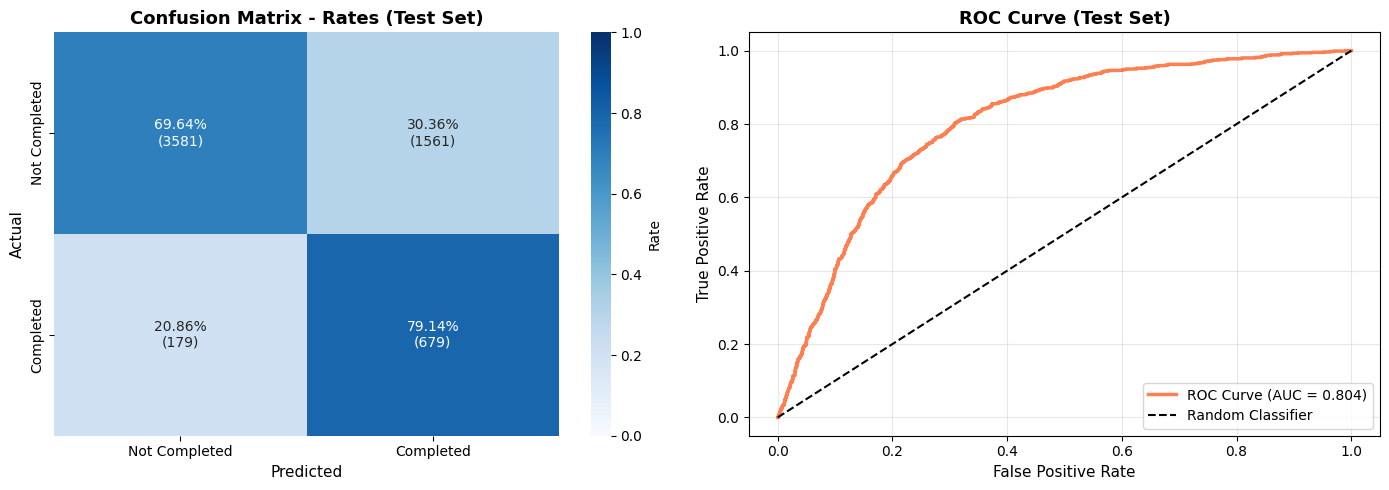



--- CLASSIFICATION REPORT (TEST SET) ---
               precision    recall  f1-score   support

Not Completed       0.95      0.70      0.80      5142
    Completed       0.30      0.79      0.44       858

     accuracy                           0.71      6000
    macro avg       0.63      0.74      0.62      6000
 weighted avg       0.86      0.71      0.75      6000


✓ Model evaluation complete!


In [44]:
# === LOGISTIC REGRESSION MODEL ===
print("=== BUILDING LOGISTIC REGRESSION MODEL ===\n")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# 1. Train-Test Split (80-20)
print("=== TRAIN-TEST SPLIT ===")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTarget distribution in train set:")
print(y_train.value_counts())
print(f"Target rate: {y_train.mean():.4f}")

# 2. Feature Scaling (important for logistic regression)
print(f"\n\n=== FEATURE SCALING ===")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized (mean=0, std=1)")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# 3. Train Logistic Regression Model
print(f"\n\n=== TRAINING LOGISTIC REGRESSION ===")
logreg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    class_weight='balanced'  # Handle class imbalance
)

logreg.fit(X_train_scaled, y_train)
print("✓ Model training complete")

# 4. Make Predictions
print(f"\n\n=== MAKING PREDICTIONS ===")
y_pred_train = logreg.predict(X_train_scaled)
y_pred_test = logreg.predict(X_test_scaled)

y_pred_proba_train = logreg.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = logreg.predict_proba(X_test_scaled)[:, 1]

print("✓ Predictions generated")

# 5. Model Evaluation
print(f"\n\n{'='*60}")
print("MODEL PERFORMANCE")
print('='*60)

print("\n--- TRAINING SET ---")
print(f"Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"Recall:    {recall_score(y_train, y_pred_train):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_pred_train):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_pred_proba_train):.4f}")

print("\n--- TEST SET ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_test):.4f}")

# 6. Confusion Matrix
print(f"\n\n--- CONFUSION MATRIX (TEST SET) ---")
cm = confusion_matrix(y_test, y_pred_test)
# Normalize by row (true labels) to get rates
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Raw counts:")
print(cm)
print(f"\nTrue Negatives:  {cm[0, 0]} ({cm_normalized[0, 0]*100:.2f}%)")
print(f"False Positives: {cm[0, 1]} ({cm_normalized[0, 1]*100:.2f}%)")
print(f"False Negatives: {cm[1, 0]} ({cm_normalized[1, 0]*100:.2f}%)")
print(f"True Positives:  {cm[1, 1]} ({cm_normalized[1, 1]*100:.2f}%)")

print(f"\nRates (normalized by actual class):")
print(f"True Negative Rate (Specificity):  {cm_normalized[0, 0]:.4f}")
print(f"False Positive Rate:                {cm_normalized[0, 1]:.4f}")
print(f"False Negative Rate:                {cm_normalized[1, 0]:.4f}")
print(f"True Positive Rate (Recall/Hit Rate): {cm_normalized[1, 1]:.4f}")

# Visualize Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion Matrix with Rates
# Create annotations with both percentage and count
annot_labels = np.array([[f'{cm_normalized[i, j]:.2%}\n({cm[i, j]})' 
                          for j in range(cm.shape[1])] 
                         for i in range(cm.shape[0])])
sns.heatmap(cm_normalized, annot=annot_labels, fmt='', cmap='Blues', ax=axes[0],
            xticklabels=['Not Completed', 'Completed'],
            yticklabels=['Not Completed', 'Completed'],
            vmin=0, vmax=1, cbar_kws={'label': 'Rate'})
axes[0].set_title('Confusion Matrix - Rates (Test Set)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

# Plot 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
axes[1].plot(fpr, tpr, color='coral', linewidth=2.5, 
             label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba_test):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve (Test Set)', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Classification Report
print(f"\n\n--- CLASSIFICATION REPORT (TEST SET) ---")
print(classification_report(y_test, y_pred_test, 
                          target_names=['Not Completed', 'Completed']))

print(f"\n{'='*60}")
print("✓ Model evaluation complete!")
print('='*60)


In [ ]:
# === FEATURE IMPORTANCE ANALYSIS ===
print("=== FEATURE IMPORTANCE (COEFFICIENTS) ===\n")

# Extract coefficients and feature names
coefficients = logreg.coef_[0]
feature_names = X.columns

# Create dataframe of features and their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top 15 Positive Coefficients
top_positive = feature_importance.nlargest(15, 'Coefficient')
axes[0].barh(range(len(top_positive)), top_positive['Coefficient'], color='green', alpha=0.7)
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels(top_positive['Feature'], fontsize=9)
axes[0].set_xlabel('Coefficient Value', fontsize=11)
axes[0].set_title('Top 15 Positive Features (Increase Success)', fontsize=12, fontweight='bold')
axes[0].grid(True, axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Plot 2: Top 15 Negative Coefficients
top_negative = feature_importance.nsmallest(15, 'Coefficient')
axes[1].barh(range(len(top_negative)), top_negative['Coefficient'], color='red', alpha=0.7)
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels(top_negative['Feature'], fontsize=9)
axes[1].set_xlabel('Coefficient Value', fontsize=11)
axes[1].set_title('Top 15 Negative Features (Decrease Success)', fontsize=12, fontweight='bold')
axes[1].grid(True, axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Summary insights
print(f"\n\n=== KEY INSIGHTS ===")
print(f"Most positive feature: {feature_importance.iloc[0]['Feature']}")
print(f"  Coefficient: {feature_importance.iloc[0]['Coefficient']:.4f}")
print(f"\nMost negative feature: {feature_importance.nsmallest(1, 'Coefficient')['Feature'].values[0]}")
print(f"  Coefficient: {feature_importance.nsmallest(1, 'Coefficient')['Coefficient'].values[0]:.4f}")

print("\n✓ Feature importance analysis complete!")
